In [1]:
# -*- coding: utf-8 -*-

"""
This program makes learning ev-gmm.
"""

'\nThis program makes learning ev-gmm.\n'

In [2]:
# __future__ module make compatible python2 and python3
from __future__ import division, print_function

# basic modules
import os
import os.path
import time

# for warning ignore
import warnings
#warning.filterwarnings('ignore')

# for file system manupulation 
from shutil import rmtree 
import glob
import argparse

# for save object
import pickle

# for make glaph
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 5)
import librosa.display

# for scientific computing
import numpy as np
from numpy.linalg import norm 
from sklearn.decomposition import PCA
from sklearn.mixture import GMM # GMM class cannot use after sklearn 0.20.0
import sklearn.mixture
#from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
from sklearn.preprocessing import StandardScaler
import scipy.sparse
from scipy.signal import firwin, lfilter

# for display audio controler
from IPython.display import Audio

# for manuplate audio data
import soundfile as sf
import pyworld as pw
import pysptk
from dtw import dtw
from fastdtw import fastdtw

In [3]:
class WORLD(object):
    """
    WORLD based speech analyzer and synthezer.
    
    Ref : https://github.com/k2kobayashi/sprocket/
    """
    def __init__(self, fs=16000, fftl=1024, shiftms=5.0, minf0=40.0, maxf0=500.0):
        """
        Parameters
        ----------
        fs : int 
            Sampling frequency 
        fftl : int
            FFT length
        shiftms : float
            Shift length [ms]
        minf0 : float
            Floor in F0 estimation
        maxf0 : float
            Seli in F0 estimation
        """
        
        self.fs = fs
        self.fftl = fftl
        self.shiftms = shiftms
        self.minf0 = minf0
        self.maxf0 = maxf0
        
    def analyze(self, x):
        """
        Analyze acoustic featueres.
        
        Parameters
        ----------
        x : array, shape(`T`)
            monoral speech signal in time domain
        
        Returns
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        sp : array, shape(`T`, `fftl / 2 + 1`)
            Spectral envelope sequence
        ap : array, shape(`T`, `fftl / 2 + 1`)
            aperiodicity sequence
        """
        
        f0, time_axis = pw.harvest(x, self.fs, f0_floor=self.minf0,
                                   f0_ceil=self.maxf0, frame_period=self.shiftms)
        sp = pw.cheaptrick(x, f0, time_axis, self.fs, fft_size=self.fftl)
        ap = pw.d4c(x, f0, time_axis, self.fs, fft_size=self.fftl)
        
        assert sp.shape == ap.shape
        
        return f0, sp, ap
    
    def analyze_f0(self, x):
        """
        Analyze f0.
        
        Parameters
        ----------
        x : array, shape(`T`)
            monoral speech signal in time domain
        
        Returns
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        """

        f0, time_axis = pw.harvest(x, self.fs, f0_floor=self.minf0,
                                   f0_ceil=self.maxf0, frame_period=self.shiftms)
        
        assert f0.shape == x.shape()
        
        return f0
    
    def synthesis(self, f0, sp, ap):
        """
        Re-synthesizes a speech waveform from acoustic featueres.
        
        Parameters
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        sp : array, shape(`T`, `fftl / 2 + 1`)
            Spectral envelope sequence
        ap : array, shape(`T`, `fftl / 2 + 1`)
            aperiodicity sequence
        """

        return pw.synthesize(f0, sp, ap, self.fs, frame_period=self.shiftms)

In [4]:
class FeatureExtractor(object):
    """
    Analyze acoustic features from a waveform.
    
    This class may have several types of estimeter like WORLD or STRAIGHT.
    Default type is WORLD.
    
    Ref : https://github.com/k2kobayashi/sprocket/
    """
    
    def __init__(self, analyzer='world', fs=16000, fftl=1024, 
                 shiftms=5.0, minf0=50.0, maxf0=500.0):
        """
        Parameters
        ----------
        analyzer : str
            Analyzer
        fs : int 
            Sampling frequency 
        fftl : int
            FFT length
        shiftms : float
            Shift length [ms]
        minf0 : float
            Floor in F0 estimation
        maxf0 : float
            Seli in F0 estimation
        """
        
        self.analyzer = analyzer
        self.fs = fs
        self.fftl = fftl
        self.shiftms = shiftms
        self.minf0 = minf0
        self.maxf0 = maxf0
    
        if self.analyzer == 'world':
            self.analyzer = WORLD(fs=self.fs, fftl=self.fftl, 
                                  minf0=self.minf0, maxf0=self.maxf0, shiftms=self.shiftms)
        else:
            raise('Analyzer Error : not support type, see FeatureExtractor class.')
        
        self._f0 = None
        self._sp = None
        self._ap = None
        
    def analyze(self, x):
        """
        Analyze acoustic featueres.
        
        Parameters
        ----------
        x : array, shape(`T`)
            monoral speech signal in time domain
        
        Returns
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        sp : array, shape(`T`, `fftl / 2 + 1`)
            Spectral envelope sequence
        ap : array, shape(`T`, `fftl / 2 + 1`)
            aperiodicity sequence
        """
        
        self.x = np.array(x, dtype=np.float)
        self._f0, self._sp, self._ap = self.analyzer.analyze(self.x)
        
        # check f0 < 0
        self._f0[self._f0 < 0] = 0
        
        if np.sum(self._f0) == 0.0:
            print("Warning : F0 values are all zero.")
        
        return self._f0, self._sp, self._ap
    
    def analyze_f0(self, x):
        """
        Analyze f0.
        
        Parameters
        ----------
        x : array, shape(`T`)
            monoral speech signal in time domain
        
        Returns
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        """

        self.x = np.array(x, dtype=np.float)
        self._f0 = self.analyzer.analyze_f0(self.x)

        # check f0 < 0
        self._f0[self._f0 < 0] = 0
        
        if np.sum(self._f0) == 0.0:
            print("Warning : F0 values are all zero.")
        
        return self._f0
    
    def mcep(self, dim=24, alpha=0.42):
        """
        Convert mel-cepstrum sequence from spectral envelope.
        
        Parameters
        ----------
        dim : int
            mel-cepstrum dimension
        alpha : float
            parameter of all-path filter
        
        Returns
        ----------
        mcep : array, shape(`T`, `dim + 1`)
            mel-cepstrum sequence
        """        
        
        self._analyzed_check()
        
        return pysptk.sp2mc(self._sp, dim, alpha)
    
    def codeap(self):
        """
        """
        self._analyzed_check()
        
        return pw.code_aperiodicity(self._ap, self.fs)
    
    def npow(self):
        """
        Normalized power sequence from spectral envelope.
        
        Returns
        ----------
        npow : vector, shape(`T`, `1`)
            Normalized power sequence of the given waveform
        """
        
        self._analyzed_check()
        
        npow = np.apply_along_axis(self._spvec2pow, 1, self._sp)
        
        meanpow = np.mean(npow)
        npow = 10.0 * np.log10(npow / meanpow)
        
        return npow
    
    def _spvec2pow(self, specvec):
        """
        """
        fftl2 = len(specvec) - 1
        fftl = fftl2 * 2
        
        power = specvec[0] + specvec[fftl2]
        for k in range(1, fftl2):
            power += 2.0 * specvec[k]
        power /= fftl
        
        return power
        
    def _analyzed_check(self):
        if self._f0 is None and self._sp is None and self._ap is None:
            raise('Call FeatureExtractor.analyze() before this method.')

In [5]:
class Synthesizer(object):
    """
    Synthesize a waveform from acoustic features.
    
    Ref : https://github.com/k2kobayashi/sprocket/
    """
    def __init__(self, fs=16000, fftl=1024, shiftms=5.0):
        """
        Parameters
        ----------
        fs : int 
            Sampling frequency 
        fftl : int
            FFT length
        shiftms : float
            Shift length [ms]
        """
        
        self.fs = fs
        self.fftl = fftl
        self.shiftms = shiftms
    
    def synthesis(self, f0, mcep, ap, rmcep=None, alpha=0.42):
        """
        Re-synthesizes a speech waveform from acoustic featueres.
        
        Parameters
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        mcep : array, shape(`T`, `dim`)
            mel-cepstrum sequence
        ap : array, shape(`T`, `fftl / 2 + 1`)
            aperiodicity sequence
        rmcep : array, shape(`T`, `dim`)
            array of reference mel-cepstrum sequence
        alpha : float
            parameter of all-path filter
            
        Returns
        ----------
        wav : array,
            syntesized waveform
        """
        
        if rmcep is not None:
            # power modification
            mcep = mod_power(mcep, rmcep, alpha=alpha)
        
        sp = pysptk.mc2sp(mcep, alpha, self.fftl)
        wav = pw.synthesize(f0, sp, ap, self.fs, frame_period=self.shiftms)
        
        return wav
        
    def synthesis_diff(self, x, diffmcep, rmcep=None, alpha=0.42):
        """
        Re-synthesizes a speech waveform from acoustic featueres.
        filtering with a differential mel-cepstrum.
        
        Parameters
        ----------
        x : array, shape(`samples`)
            array of waveform sequence
        diffmcep : array, shape(`T`, `dim`)
            array of differential mel-cepstrum sequence
        rmcep : array, shape(`T`, `dim`)
            array of reference mel-cepstrum sequence
        alpha : float
            parameter of all-path filter
            
        Returns
        ----------
        wav : array,
            syntesized waveform
        """      
        
        x = x.astype(np.float64)
        dim = diffmcep.shape[1] - 1 
        shiftl = int(self.fs / 1000 * self.shiftms)
        
        if rmcep is not None:
            # power modification
            diffmcep = mod_power(rmcep + diffmcep, rmcep, alpha=alpha) - rmcep        
        
        # mc2b = transform mel-cepstrum to MLSA digital filter coefficients.
        b = np.apply_along_axis(pysptk.mc2b, 1, diffmcep, alpha)
        
        mlsa_fil = pysptk.synthesis.Synthesizer(pysptk.synthesis.MLSADF(dim, alpha=alpha),
                                                shiftl)
        wav = mlsa_fil.synthesis(x, b)
        
        return wav
    
    def synthesis_sp(self, f0, sp, ap):
        """
        Re-synthesizes a speech waveform from acoustic featueres.
        
        Parameters
        ----------
        f0 : array, shape(`T`)
            F0 sequence
        spc : array, shape(`T`, `dim`)
            mel-cepstrum sequence
        ap : array, shape(`T`, `fftl / 2 + 1`)
            aperiodicity sequence
            
        Returns
        ----------
        wav : array,
            syntesized waveform
        """      
        
        wav = pw.synthesize(f0, sp, ap, self.fs, frame_period=self.shiftms)
        
        return wav
    
def mod_power(cvmcep, rmcep, alpha=0.42, irlen=256):
    """
    power modification based on inpuulse responce

    Parameters
    ----------
    cvmcep : array, shape(`T`, `dim`)
        array of converted mel-cepstrum
    rmcep : arraym shape(`T`, `dim`)
        array of reference mel-cepstrum
    alpha : float
        parameter of all-path filter
    irlen : int
        Length for IIR filter

    Returns
    ----------
    modified_cvmcep : array, shape(`T`, `dim`)
        array of power modified converted mel-cepstrum
    """

    if rmcep.shape != cvmcep.shape:
        raise ValueError(
            "The shape of the converted and reference mel-cepstrum are different : {} / {}.format(cvmcep.shape, rmcep.shape)"
        )

    # mc2e = Compute energy from mel-cepstrum. e-option
    cv_e = pysptk.mc2e(cvmcep, alpha=alpha, irlen=irlen)
    r_e = pysptk.mc2e(rmcep, alpha=alpha, irlen=irlen)

    dpow = np.log(r_e / cv_e) / 2

    modified_cvmcep = np.copy(cvmcep)
    modified_cvmcep[:, 0] += dpow

    return modified_cvmcep

In [6]:
# def util methods
def melcd(array1, array2):
    """
    calculate mel-cepstrum distortion
    
    Parameters
    ----------
    array1, array2 : array, shape(`T`, `dim`) or shape(`dim`)
        Array of original and target.
    
    Returns
    ----------
    mcd : scala, number > 0
        Scala of mel-cepstrum distoriton
    """
    if array1.shape != array2.shape:
        raise ValueError(
            "The shape of both array are different : {} / {}.format(array1.shape,array2.shape)"
        )    
   
    if array1.ndim == 2:
        diff = array1 - array2
        mcd = 10.0 / np.log(10) * np.mean(np.sqrt(2.0 * np.sum(diff ** 2, axis=1)))
    elif array1.ndim == 1:
        diff = array1 - array2
        mcd = 10.0 / np.log(10) * np.sqrt(2.0 * np.sum(diff ** 2))
    else:
        raise ValueError("Dimension mismatch.")
        
    return mcd

def delta(data, win=[-1.0, 1.0, 0]):
    """
    calculate delta component
    
    Parameters
    ----------
    data : array, shape(`T`, `dim`)
        Array of static matrix sequence.
    win : array, shape(`3`)
        The shape of window matrix.
    
    Returns
    ----------
    delta : array, shape(`T`, `dim`)
        Array of delta matrix sequence.
    """
    
    if data.ndim == 1:
        # change vector into 1d-array
        T = len(data)
        dim = data.ndim
        data = data.reshape(T, dim)
    else:
        T, dim = data.shape
    
    win = np.array(win, dtype=np.float64)
    delta = np.zeros((T, dim))
    
    delta[0] = win[0] * data[0] + win[1] * data[1]
    delta[-1] = win[0] * data[-2] + win[1] * data[-1]
    
    for i in range(len(win)):
        delta[1:T - 1] += win[i] * delta[i:T - 2 + i]
    
    return delta

def static_delta(data, win=[-1.0, 1.0, 0]):
    """
    calculate static and delta component
    
    Parameters
    ----------
    data : array, shape(`T`, `dim`)
        Array of static matrix sequence.
    win : array, shape(`3`)
        The shape of window matrix.
    
    Returns
    ----------
    sddata : array, shape(`T`, `dim * 2`)
        Array of static and delta matrix sequence.
    """
    
    sddata = np.c_[data, delta(data, win)]
    
    assert sddata.shape[1] == data.shape[1] * 2
    
    return sddata

def construct_static_and_delta_matrix(T, D, win=[-1.0, 1.0, 0]):
    """
    calculate static and delta transformation matrix
    
    Parameters
    ----------
    T : scala, `T`
        Scala of time length
    D : scala, `D`
        Scala of the number of dimension.
    win : array, shape(`3`)
        The shape of window matrix.
    
    Returns
    ----------
    W : array, shape(`2 * D * T`, `D * T`)
        Array of static and delta transformation matrix.
    """
    
    static = [0, 1, 0]
    delta = win
    assert len(static) == len(delta)
    
    # generate full W
    DT = D * T
    ones = np.ones(DT)
    row = np.arange(2 * DT).reshape(2 * T, D) # generate serial numbers
    static_row = row[::2] # [1,2,3,4,5] => [1,3,5]
    delta_row = row[1::2] # [1,2,3,4,5] => [2,4]
    col = np.arange(DT)
    
    data = np.array([ones * static[0], ones * static[1],
                      ones * static[2], ones * delta[0],
                      ones * delta[1], ones * delta[2]]).flatten()
    row = np.array([[static_row] * 3, [delta_row] * 3]).flatten()
    col = np.array([[col - D, col, col + D] * 2]).flatten()

    # remove component at first and end frame
    valid_idx = np.logical_not(np.logical_or(col < 0, col >= DT))
    
    W = scipy.sparse.csr_matrix(
        (data[valid_idx], (row[valid_idx], col[valid_idx])), shape=(2 * DT, DT))
    W.eliminate_zeros()
    
    return W
    
def extfrm(data, npow, power_threshold=-20):
    """
    Extract frame over the power threshold
    
    Parameters
    ----------
    data : array, shape(`T`, `dim`)
        array of input data
    npow : array, shape(`T`)
        vector of normalized power sequence
    threshold : scala
        scala of power threshold [dB]
        
    Returns
    ----------
    data : array, shape(`T_ext`, `dim`)
        remaining data after extracting frame
        `T_ext` <= `T`
    """
    T = data.shape[0]
    if T != len(npow):
        raise("Length of two vectors is different.")
        
    valid_index = np.where(npow > power_threshold)
    extdata = data[valid_index]
    assert extdata.shape[0] <= T
    
    return extdata

def estimate_twf(orgdata, tardata, distance='melcd', fast=True, otflag=None):
    """
    time warping function estimator
    
    Parameters
    ----------
    orgdata : array, shape(`T_org`, `dim`)
        array of source feature
    tardata : array, shape(`T_tar`, `dim`)
        array of target feature
    distance : str 
        distance function
    fast : bool
        use fastdtw instead of dtw
    otflag : str
        Alignment into the length of specification
        'org' : alignment into original length
        'tar' : alignment into target length   
    
    Returns
    ----------
    twf : array, shape(`2`, `T`)
        time warping function between original and target
    """
    
    if distance == 'melcd':
        def distance_func(x, y): return melcd(x, y)
    else:
        raise ValueError('this distance method is not support.')
    
    if fast:
        _, path = fastdtw(orgdata, tardata, dist=distance_func)
        twf = np.array(path).T
    else:
        _, _, _, twf = dtw(orgdata, tardata, distance_func) 
        
    if otflag is not None:
        twf = modify_twf(twf, otflag=otflag)
    
    return twf

def align_data(org_data, tar_data, twf):
    """
    get aligned joint feature vector
    
    Parameters
    ----------
    org_data : array, shape(`T_org`, `dim_org`)
        Acoustic feature vector of original speaker
    tar_data : array, shape(`T_tar`, `dim_tar`)
        Acoustic feature vector of target speaker
    twf : array, shape(`2`, `T`)
        time warping function between original and target
        
    Returns
    ----------
    jdata : array, shape(`T_new`, `dim_org + dim_tar`)
        Joint feature vector between source and target
    """
    
    jdata = np.c_[org_data[twf[0]], tar_data[twf[1]]]
    return jdata

def modify_twf(twf, otflag=None):
    """
    align specified length
    
    Parameters
    ----------
    twf : array, shape(`2`, `T`)
        time warping function between original and target
    otflag : str
        Alignment into the length of specification
        'org' : alignment into original length
        'tar' : alignment into target length   
    
    Returns
    ----------
    mod_twf : array, shape(`2`, `T_new`)
        time warping function of modified alignment
    """
    
    if otflag == 'org':
        of, indice = np.unique(twf[0], return_index=True)
        mod_twf = np.c_[of, twf[1][indice]].T
    elif otflag == 'tar':
        tf, indice = np.unique(twf[1], return_index=True)
        mod_twf = np.c_[twf[0][indice], tf].T 
    
    return mod_twf

def low_cut_filter(x, fs, cutoff=70):
    """
    low cut filter
    
    Parameters
    ----------
    x : array, shape('samples')
        waveform sequence
    fs : array, int
        Sampling frequency
    cutoff : float
        cutoff frequency of low cut filter
    
    Returns
    ----------
    lct_x : array, shape('samples')
        Low cut filtered waveform sequence
    """
    
    nyquist = fs // 2
    norm_cutoff = cutoff / nyquist
    
    # low cut filter
    fil = firwin(255, norm_cutoff, pass_zero=False)
    lct_x = lfilter(fil, 1, x)
    
    return lct_x

def extsddata(data, npow, power_threshold=-20):
    """
    get power extract static and delta feature vector
    
    Parameters
    ----------
    data : array, shape(`T`, `dim`)
        acoustic feature vector
    npow : array, shape(`T`)
        normalized power vector
    power_threshold : float
        power threshold
    
    Returns
    ----------
    extsddata : array, shape(`T_new`, `dim * 2`)
        silence remove static and delta feature vector
    """
    
    extsddata = extfrm(static_delta(data), npow, power_threshold=power_threshold)
    return extsddata

def transform_jnt(array_list):
    num_files = len(array_list)
    for i in range(num_files):
        if i == 0:
            jnt = array_list[i]
        else:
            jnt = np.r_[jnt, array_list[i]]
    return jnt
    

In [7]:
class F0statistics(object):
    """
    Estimate F0 statistics and convert F0
    """
    def __init__(self):
        pass
    
    def estimate(self, f0list):
        """
        estimate F0 statistics from list of f0
        
        Parameters
        ----------
        f0list : list, shape(`f0num`)
            List of several F0 sequence
        
        Returns
        ----------
        f0stats : array, shape(`[mean, std]`)
            values of mean and standard deviation for log f0
        """
        
        n_files = len(f0list)
        assert n_files != 0

        for i in range(n_files):
            f0 = f0list[i]
            nonzero_indices = np.nonzero(f0)
            if i == 0:
                f0s = np.log(f0[nonzero_indices])
            else:
                f0s = np.r_[f0s, np.log(f0[nonzero_indices])]
        
        f0stats = np.array([np.mean(f0s), np.std(f0s)])
        
        return f0stats

    def convert(self, f0, orgf0stats, tarf0stats):
        """
        convert F0 based on F0 statistics
        
        Parameters
        ----------
        f0 : array, shape(`T`, `1`)
            array of F0 sequence
        orgf0stats : array, shape(`[mean, std]`)
            vectors of mean and standard deviation of log f0 for original speaker
        tarf0stats : array, shape(`[mean, std]`)
            vectors of mean and standard deviation of log f0 for target speaker
        
        Returns
        ----------
        cvf0 : array, shape(`T`, `1`)
            array of converted F0 sequence
        """
        
        # get length and dimension
        T = len(f0)
        
        # perform f0 conversion
        cvf0 = np.zeros(T)
        
        nonzero_indices  = f0 > 0
        cvf0[nonzero_indices] = np.exp((tarf0stats[1] / orgf0stats[1]) * (np.log(f0[nonzero_indices]) - orgf0stats[0]) + tarf0stats[0])
        
        return cvf0

In [8]:
class GV(object):
    """
    Estimate statistics and perform postfilter based on the GV statistics.
    """
    def __init__(self):
        pass
    
    def estimate(self, datalist):
        """
        estimate GV statistics from list of data
        
        Parameters
        ----------
        datalist : list, shape(`num_data`)
            List of several data ([T, dim]) sequence
        
        Returns
        ----------
        gvstats : array, shape(`2`, `dim`)
            array of mean and standard deviation for GV
        """
        
        n_files = len(datalist)
        assert n_files != 0
        
        var = []
        for i in range(n_files):
            data = datalist[i]
            var.append(np.var(data, axis=0))
            
        # calculate vm and vv
        vm = np.mean(np.array(var), axis=0)
        vv = np.var(np.array(var), axis=0)
        gvstats = np.r_[vm, vv]
        gvstats = gvstats.reshape(2, len(vm))
        
        return gvstats

    def postfilter(self, data, gvstats, cvgvstats=None, alpha=1.0, startdim=1):
        """
        perform postfilter based on GV statistics into data
        
        Parameters
        ----------
        data : array, shape(`T`, `dim`)
            array of data sequence
        gvstats : array, shape(`2`, `dim`)
            array of mean and variance for target GV
        cvgvstats : array, shape(`2`, `dim`)
            array of mean and variance for converted GV
        alpha : float
            morphing coefficient between GV transformed data and data.
            alpha * gvpf(data) + (1 - alpha) * data
        startdim : int
            start dimension to perform GV postfilter
        
        Returns
        ----------
        filtered_data : array, shape(`T`, `data`)
            array of GV postfiltered data sequnece
        """
        
        # get length and dimension
        T, dim = data.shape
        assert gvstats is not None
        assert dim == gvstats.shape[1]
        
        # calculate statics of input data
        datamean = np.mean(data, axis=0)
        
        if cvgvstats is None:
            # use variance of the given data
            datavar = np.var(data, axis=0)
        else:
            # use variance of trained gv stats
            datavar = cvgvstats[0]
        
        # perform GV postfilter
        filterd = np.sqrt(gvstats[0, startdim:] / datavar[startdim:]) * (data[:, startdim:] - datamean[startdim:]) + datamean[startdim:]
        
        filterd_data = np.c_[data[:, :startdim], filterd]
        
        return alpha * filterd_data + (1 - alpha) * data

In [9]:
# 0. config path
__versions = "pre-stored-jp"
__same_path = "./utterance/" + __versions + "/"
pre_stored_source_list = __same_path + 'pre-source/**/V01/T01/**/*.wav'
pre_stored_list = __same_path + "pre/**/V01/T01/**/*.wav"
output_path = __same_path + "output/"

# 1. estimate features
feat = FeatureExtractor()
synthesizer = Synthesizer()

org_f0list = None
org_splist = None
org_mceplist = None
org_aplist = None
org_npowlist = None
org_codeaplist = None

if os.path.exists(output_path + "_org_f0.pickle") \
    and os.path.exists(output_path + "_org_sp.pickle") \
    and os.path.exists(output_path + "_org_ap.pickle") \
    and os.path.exists(output_path + "_org_mcep.pickle") \
    and os.path.exists(output_path + "_org_npow.pickle") \
    and os.path.exists(output_path + "_org_codeap.pickle"):
        
    with open(output_path + "_org_f0.pickle", 'rb') as f:    
        org_f0list = pickle.load(f)
    with open(output_path + "_org_sp.pickle", 'rb') as f:   
        org_splist = pickle.load(f)
    with open(output_path + "_org_ap.pickle", 'rb') as f:  
        org_aplist = pickle.load(f)
    with open(output_path + "_org_mcep.pickle", 'rb') as f:  
        org_mceplist = pickle.load(f)
    with open(output_path + "_org_npow.pickle", 'rb') as f:  
        org_npowlist = pickle.load(f)
    with open(output_path + "_org_codeap.pickle", 'rb') as f:  
        org_codeaplist = pickle.load(f) 
else:
    org_f0list = []
    org_splist = []
    org_mceplist = []
    org_aplist = []
    org_npowlist = []
    org_codeaplist = []
    for files in sorted(glob.iglob(pre_stored_source_list, recursive=True)):
        wavf = files
        x, fs = sf.read(wavf)
        x = np.array(x, dtype=np.float)
        x = low_cut_filter(x, fs, cutoff=70)
        assert fs == 16000

        print("extract acoustic featuers: " + wavf)

        f0, sp, ap = feat.analyze(x)
        mcep = feat.mcep()
        npow = feat.npow()
        codeap = feat.codeap()
        #name, ext = os.path.splitext(wavf)
        #np.save(name + "_or_f0", f0)
        #np.save(name + "_or_sp", sp)
        #np.save(name + "_or_ap", ap)
        #np.save(name + "_or_mcep", mcep)
        #np.save(name + "_or_codeap", codeap)
        org_f0list.append(f0)
        org_splist.append(sp)
        org_mceplist.append(mcep)
        org_aplist.append(ap)
        org_npowlist.append(npow)
        org_codeaplist.append(codeap)

        #wav = synthesizer.synthesis(f0, mcep, ap)
        #wav = np.clip(wav, -32768, 32767)
        #sf.write(name + "_ansys.wav", wav, fs)

    with open(output_path + "_org_f0.pickle", 'wb') as f:    
        pickle.dump(org_f0list, f)
    with open(output_path + "_org_sp.pickle", 'wb') as f:   
        pickle.dump(org_splist, f)
    with open(output_path + "_org_npow.pickle", 'wb') as f:   
        pickle.dump(org_npowlist, f)
    with open(output_path + "_org_ap.pickle", 'wb') as f:  
        pickle.dump(org_aplist, f)
    with open(output_path + "_org_mcep.pickle", 'wb') as f:  
        pickle.dump(org_mceplist, f)
    with open(output_path + "_org_codeap.pickle", 'wb') as f:  
        pickle.dump(org_codeaplist, f) 

mid_f0list = None
mid_mceplist = None
mid_aplist = None
mid_npowlist = None
mid_splist = None
mid_codeaplist = None        

if os.path.exists(output_path + "_mid_f0.pickle") \
    and os.path.exists(output_path + "_mid_sp_0_.pickle") \
    and os.path.exists(output_path + "_mid_ap_0_.pickle") \
    and os.path.exists(output_path + "_mid_mcep.pickle") \
    and os.path.exists(output_path + "_mid_npow.pickle") \
    and os.path.exists(output_path + "_mid_codeap.pickle"):
        
    with open(output_path + "_mid_f0.pickle", 'rb') as f:    
        mid_f0list = pickle.load(f)
    for i in range(0, len(org_splist)*21, len(org_splist)):  
        with open(output_path + "_mid_sp_{}_.pickle".format(i), 'rb') as f:
            temp_splist = pickle.load(f)
            if mid_splist is None:
                mid_splist = temp_splist
            else:
                mid_splist = mid_splist + temp_splist
    for i in range(0, len(org_aplist)*21, len(org_aplist)):  
        with open(output_path + "_mid_ap_{}_.pickle".format(i), 'rb') as f:
            temp_aplist = pickle.load(f)
            if mid_aplist is None:
                mid_aplist = temp_aplist
            else:
                mid_aplist = mid_aplist + temp_aplist    
    with open(output_path + "_mid_mcep.pickle", 'rb') as f:  
        mid_mceplist = pickle.load(f)
    with open(output_path + "_mid_npow.pickle", 'rb') as f:  
        mid_npowlist = pickle.load(f)
    with open(output_path + "_mid_codeap.pickle", 'rb') as f:  
        mid_codeaplist = pickle.load(f) 
else:        
    mid_f0list = []
    mid_mceplist = []
    mid_aplist = []
    mid_npowlist = []
    mid_splist = []
    mid_codeaplist = []

    for files in sorted(glob.iglob(pre_stored_list, recursive=True)):
        wavf = files
        x, fs = sf.read(wavf)
        x = np.array(x, dtype=np.float)
        x = low_cut_filter(x, fs, cutoff=70)
        assert fs == 16000

        print("extract acoustic featuers: " + wavf)

        f0, sp, ap = feat.analyze(x)
        mcep = feat.mcep()
        npow = feat.npow()
        codeap = feat.codeap()
        name, ext = os.path.splitext(wavf)
        #np.save(name + "_or_f0", f0)
        #np.save(name + "_or_sp", sp)
        #np.save(name + "_or_ap", ap)
        #np.save(name + "_or_mcep", mcep)
        #np.save(name + "_or_codeap", codeap)
        mid_f0list.append(f0)
        mid_splist.append(sp)
        mid_mceplist.append(mcep)
        mid_aplist.append(ap)
        mid_npowlist.append(npow)
        mid_codeaplist.append(codeap)

        #wav = synthesizer.synthesis(f0, mcep, ap)
        #wav = np.clip(wav, -32768, 32767)
        #sf.write(name + "_ansys.wav", wav, fs)
        
    with open(output_path + "_mid_f0.pickle", 'wb') as f:
        print(f)
        pickle.dump(mid_f0list, f)
    with open(output_path + "_mid_npow.pickle", 'wb') as f:
        print(f)
        pickle.dump(mid_npowlist, f)
    for i in range(0, len(mid_splist), len(org_splist)):
        with open(output_path + "_mid_sp_{}_.pickle".format(i), 'wb') as f:   
            print(f)
            pickle.dump(mid_splist[i:i+len(org_splist)], f)
    for i in range(0, len(mid_aplist), len(org_aplist)):
        with open(output_path + "_mid_ap_{}_.pickle".format(i), 'wb') as f:
            print(f)
            pickle.dump(mid_aplist[i:i+len(org_aplist)], f)
    with open(output_path + "_mid_mcep.pickle", 'wb') as f:
        print(f)
        pickle.dump(mid_mceplist, f)
    with open(output_path + "_mid_codeap.pickle", 'wb') as f:
        print(f)
        pickle.dump(mid_codeaplist, f) 

In [10]:
class GMMTrainer(object):
    """
    this class offers the training of GMM with several types of covariance matrix.
    
    Parameters
    ----------
    n_mix : int 
        the number of mixture components of the GMM
    n_iter : int
        the number of iteration for EM algorithm
    covtype : str
        the type of covariance matrix of the GMM
        'full': full-covariance matrix
    
    Attributes
    ---------
    param : 
        sklearn-based model parameters of the GMM
    """
    
    def __init__(self, n_mix=64, n_iter=100, covtype='full', params='wmc'):
        self.n_mix = n_mix
        self.n_iter = n_iter
        self.covtype = covtype
        self.params = params
        self.param = sklearn.mixture.GMM(n_components=self.n_mix,
                                                     covariance_type=self.covtype,
                                                     n_iter=self.n_iter, params=self.params)
        
    def train(self, jnt):
        """
        fit GMM parameter from given joint feature vector
        
        Parametes
        ---------
        jnt : array, shape(`T`, `jnt.shape[0]`)
            joint feature vector of original and target feature vector consisting of static and delta components
        """
        
        if self.covtype == 'full':
            self.param.fit(jnt)
            
        return
    
class GMMConvertor(object):
    """
    this class offers the several conversion techniques such as Maximum Likelihood Parameter Generation (MLPG)
    and Minimum Mean Square Error (MMSE).
    
    Parametes
    ---------
    n_mix : int
        the number of mixture components of the GMM
    covtype : str
        the type of covariance matrix of the GMM
        'full': full-covariance matrix
    gmmmode : str
        the type of the GMM for opening
        `None` : Normal Joint Density - GMM (JD-GMM)
    
    Attributes
    ---------
    param : 
        sklearn-based model parameters of the GMM
    w : shape(`n_mix`)
        vector of mixture component weight of the GMM
    jmean : shape(`n_mix`, `jnt.shape[0]`)
        Array of joint mean vector of the GMM
    jcov : shape(`n_mix`, `jnt.shape[0]`, `jnt.shape[0]`)
        array of joint covariance matrix of the GMM
    """
    
    def __init__(self, n_mix=64, covtype='full', gmmmode=None):
        self.n_mix = n_mix
        self.covtype = covtype
        self.gmmmode = gmmmode
        
    def open_from_param(self, param):
        """
        open GMM from GMMTrainer
        
        Parameters
        ----------
        param : GMMTrainer
            GMMTrainer class
        """
        
        self.param = param
        self._deploy_parameters()
        
        return
    
    def convert(self, data, cvtype='mlpg'):
        """
        convert data based on conditional probability density function
        
        Parametes
        ---------
        data : array, shape(`T`, `dim`)
            original data will be converted
        cvtype : str
            type of conversion technique
            `mlpg` : maximum likelihood parameter generation
            
        Returns
        ----------
        odata : array, shape(`T`, `dim`)
            converted data
        """
        
        # estimate parameter sequence
        cseq, wseq, mseq, covseq = self._gmmmap(data)
        
        if cvtype == 'mlpg':
            odata = self._mlpg(mseq, covseq)
        else:
            raise ValueError('please choose conversion mode in `mlpg`.')
        
        return odata
    
    def _gmmmap(self, sddata):
        # paramete for sequencial data
        T, sddim = sddata.shape
        
        # estimate posterior sequence
        wseq = self.pX.predict_proba(sddata)
        
        # estimate mixture sequence
        cseq = np.argmax(wseq, axis=1)
        
        mseq = np.zeros((T, sddim))
        covseq = np.zeros((T, sddim, sddim))
        for t in range(T):
            # read maximum likelihood mixture component in frame t
            m = cseq[t]
            
            # conditional mean vector sequence
            mseq[t] = self.meanY[m] + self.A[m] @ (sddata[t] - self.meanX[m])
            
            # conditional covariance sequence
            covseq[t] = self.cond_cov_inv[m]
        
        return cseq, wseq, mseq, covseq
    
    def _mlpg(self, mseq, covseq):
        # parameter for sequencial data
        T, sddim = mseq.shape
        
        # prepare W
        W = construct_static_and_delta_matrix(T, sddim // 2)
        
        # prepare D
        D = get_diagonal_precision_matrix(T, sddim, covseq)
        
        # calculate W'D
        WD = W.T @ D
        
        # W'DW
        WDW = WD @ W
        
        # W'Dm
        WDM = WD @ mseq.flatten()
        
        # estimate y = (W'DW)^-1 * W'Dm
        odata = scipy.sparse.linalg.spsolve(WDW, WDM, use_umfpack=False).reshape(T, sddim // 2)
        
        return odata
    
    def _deploy_parameters(self):
        # read JD-GMM parameters from self.param
        self.W = self.param.weights_
        self.jmean = self.param.means_
        self.jcov = self.param.covars_
        
        # devide GMM parameters into source and target parameters
        sddim = self.jmean.shape[1] // 2
        self.meanX = self.jmean[:, 0:sddim]
        self.meanY = self.jmean[:, sddim:]
        self.covXX = self.jcov[:, :sddim, :sddim]
        self.covXY = self.jcov[:, :sddim, sddim:]
        self.covYX = self.jcov[:, sddim:, :sddim]
        self.covYY = self.jcov[:, sddim:, sddim:]
        
        # change model parameter of GMM into that of gmmmode
        if self.gmmmode is None:
            pass
        else:
            raise ValueError('please choose GMM mode in [None]')
            
        # estimate parameters for conversion
        self._set_Ab()
        self._set_pX()
        
        return
    
    def _set_Ab(self):
        # calculate A and b from self.jmean, self.jcov
        sddim = self.jmean.shape[1] // 2
        
        # calculate inverse covariance for covariance XX in each mixture
        self.covXXinv = np.zeros((self.n_mix, sddim, sddim))
        for m in range(self.n_mix):
            self.covXXinv[m] = np.linalg.inv(self.covXX[m])
            
        # calculate A, b, and conditional covariance given X
        self.A = np.zeros((self.n_mix, sddim, sddim))
        self.b = np.zeros((self.n_mix, sddim))
        self.cond_cov_inv = np.zeros((self.n_mix, sddim, sddim))
        for m in range(self.n_mix):
            # calculate A (A = yxcov_m * xxcov_m^-1)
            self.A[m] = self.covYX[m] @ self.covXXinv[m]
            
            # calculate b (b = mean^Y - A * mean^X)
            self.b[m] = self.meanY[m] - self.A[m] @ self.meanX[m]
            
            # calculate conditional covariance (cov^(Y|X)^-1 = (yycov - A * xycov)^-1)
            self.cond_cov_inv[m] = np.linalg.inv(self.covYY[m] - self.A[m] @ self.covXY[m])
            
        return
    
    def _set_pX(self):
        # probability density function of X 
        self.pX = sklearn.mixture.GMM(n_components=self.n_mix, covariance_type=self.covtype)
        self.pX.weights_ = self.W
        self.pX.means_ = self.meanX
        self.pX.covars_ = self.covXX
        
        # following function is required to estimate porsterior
        # p(x | \lambda^(X))
        #self.pX.precisions_cholesky_ = _compute_precision_cholesky(self.covXX, self.covtype)
        
        return
    
def get_diagonal_precision_matrix(T, D, covseq):
    return scipy.sparse.block_diag(covseq, format='csr')        

In [11]:
def get_alignment(odata, onpow, tdata, tnpow, opow=-20, tpow=-20, sd=0, cvdata=None, given_twf=None, otflag=None, distance='melcd'):
    """
    get alignment between original and target.
    
    Parameters
    ----------
    odata : array, shape(`T`, `dim`)
        acoustic feature vector of original
    onpow : array, shape(`T`)
        Normalized power vector of original
    tdata : array, shape(`T`, `dim`)
        acoustic feature vector of target
    tnpow : array, shape(`T`)
        Normalized power vector of target
    opow : float
        power threshold of original
    tpow : float
        power threshold of target
    sd : int
        start dimension to be used for alignment
    cvdata : array, shape(`T`, `dim`)
        converted original data
    given_twf : array, shape(`T_new`, `dim * 2`)
        Alignment given twf
    otflag : str
        Alignment into the length of specification
        'org' : alignment into original length
        'tar' : alignment into target length
    distance : str
        Distance function to be used
    
    Returns
    ----------
    jdata : array, shape(`T_new`, `dim * 2`)
        joint static and delta feature vector
    twf : array, shape(`T_new`, `dim * 2`)
        Time warping function
    mcd : float
        Mel-cepstrum distortion between arrays
    """
    
    oexdata = extsddata(odata[:, sd:], onpow, power_threshold=opow)
    texdata = extsddata(tdata[:, sd:], tnpow, power_threshold=tpow)
    
    if cvdata is None:
        align_odata = oexdata
    else:
        cvexdata = extsddata(cvdata, onpow, power_threshold=opow)
        align_odata = cvexdata
    
    if given_twf is None: 
        twf = estimate_twf(align_odata, texdata, distance=distance, fast=False, otflag=otflag)
    else:
        twf = given_twf
    
    jdata = align_data(oexdata, texdata, twf)
    mcd = melcd(align_odata[twf[0]], texdata[twf[1]])
    
    return jdata, twf, mcd

def align_feature_vectors(odata, onpows, tdata, tnpows, opow=-100, tpow=-100, itnum=3, sd=0, given_twfs=None, otflag=None):
    """
    get alignment to create joint feature vector
    
    Parameters
    ----------
    odata : list, (`num_files`)
        List of original feature vectors
    onpow : list, (`num_files`)
        List of original npows
    tdata : list, (`num_files`)
        List of target feature vectors
    tnpow : list, (`num_files`)
        List of target npows
    opow : float
        power threshold of original
    tpow : float
        power threshold of target
    itnum : int
        the number of iteration
    sd : int
        start dimension of feature vector to be used for alignment
    given_twf : array, shape(`T_new`, `dim * 2`)
        use given alignment while 1st iteration
    otflag : str
        Alignment into the length of specification
        'org' : alignment into original length
        'tar' : alignment into target length
    distance : str
        Distance function to be used
    
    Returns
    ----------
    jdata : array, shape(`T_new`, `dim * 2`)
        joint static and delta feature vector
    twf : array, shape(`T_new`, `dim * 2`)
        Time warping function
    mcd : float
        Mel-cepstrum distortion between arrays
    """
    
    it = 1
    num_files = len(odata)
    cvgmm, cvdata = None, None
    for it in range(1, itnum+1):
        print('{}-th joint feature extraction starts.'.format(it))
        
        # alignment
        twfs, jfvs = [], []
        for i in range(num_files):
            if it == 1 and given_twfs is not None:
                gtwf = given_twfs[i]
            else:
                gtwf = None
            
            if it > 1:
                cvdata = cvgmm.convert(static_delta(odata[i][:, sd:]))
            
            jdata, twf, mcd = get_alignment(odata[i], onpows[i], tdata[i], tnpows[i], opow=opow, tpow=tpow,
                                            sd=sd, cvdata=cvdata, given_twf=gtwf, otflag=otflag)
            twfs.append(twf)
            jfvs.append(jdata)
            print('distortion [dB] for {}-th file: {}'.format(i+1, mcd))
            
        jnt_data = transform_jnt(jfvs)
        
        if it != itnum:
            # train GMM, if not final iteration
            datagmm = GMMTrainer()
            datagmm.train(jnt_data)
            cvgmm = GMMConvertor()
            cvgmm.open_from_param(datagmm.param)
        it += 1
    return jfvs, twfs    

In [12]:
# 2. estimate twf and jnt
if os.path.exists(output_path + "_jnt_mcep_0_.pickle"):
    pass
else:
    for i in range(0, len(mid_mceplist), len(org_mceplist)):
        org_mceps = org_mceplist
        org_npows = org_npowlist
        mid_mceps = mid_mceplist[i:i+len(org_mceps)]
        mid_npows = mid_npowlist[i:i+len(org_npows)]
        assert len(org_mceps) == len(mid_mceps)
        assert len(org_npows) == len(mid_npows)
        assert len(org_mceps) == len(org_npows)

        # dtw between original and target 0-th and silence
        print("## alignment mcep 0-th and silence ##")
        jmceps, twfs = align_feature_vectors(org_mceps, org_npows, mid_mceps, mid_npows, opow=-15, tpow=-15, sd=1)
        jnt_mcep = transform_jnt(jmceps)

        # save joint feature vectors
        with open(output_path + "_jnt_mcep_{}_.pickle".format(i), 'wb') as f:   
            print(f)
            pickle.dump(jnt_mcep, f)

## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 9.419198876763579
distortion [dB] for 2-th file: 9.218851217859147
distortion [dB] for 3-th file: 9.703404153633866
distortion [dB] for 4-th file: 10.073457806300715
distortion [dB] for 5-th file: 9.870953470320552
distortion [dB] for 6-th file: 9.879354558706861
distortion [dB] for 7-th file: 9.60745050761685
distortion [dB] for 8-th file: 9.199060748181951
distortion [dB] for 9-th file: 8.94685444986721
distortion [dB] for 10-th file: 9.53366919687101
distortion [dB] for 11-th file: 9.4348382557925
distortion [dB] for 12-th file: 9.76922542278139
distortion [dB] for 13-th file: 9.81652156943499
distortion [dB] for 14-th file: 9.683573184123958
distortion [dB] for 15-th file: 10.570206008147816
distortion [dB] for 16-th file: 9.594992724939315
distortion [dB] for 17-th file: 10.236867646745804
distortion [dB] for 18-th file: 10.287865103182822
distortion [dB] for 19-th file: 10.3

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.8555326622548876


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.840807891291023


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.581654616232571


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.151816438130711


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.917824476046218


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.2373733791601405


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.220000135359647


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 4.950117151433431


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.594894108179995


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.94094911784442


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.806412455312669


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.73294670283108


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 4.9778545850029445


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.645691483966835


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.9369627006029555


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.773872313430066


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.14005417593043


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.6512020550195405


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.115260974673125


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.933385157350893


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.200708791860704


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.924263279369287


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.527211470513607


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.7026088132026755


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.002330943107486


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.976876987009269


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.178659525009461


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.099264199460174


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.0848495112693515


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.435117244792115


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.74350702111676


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.63322814714001


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.19337891066693


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.9755638962754025


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.9546834159440225


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.929001948631098


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.000788566792391


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.020969844803895


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.875206679983847


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.896255159230194


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.664708760833893


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.13244887061087


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.372220394697538


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.08295260383843


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.989263283337889


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.665694364921909


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.62074885142147


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.923348883388574


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.554336604838782


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 4.999050103221014


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.74188110378444


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 4.859075936072129


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.290528780756874


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 4.944751713210619


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.508864915902297


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.697558907122299


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.6872319677475


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.605151298325641


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 4.93711391493803


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.499942148203386


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.704154318683956


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.674546769476875


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.287551172096284


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.519918688876992


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.953978873684951


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.75406358583836


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.261725741197639


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.638565825905853


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.248822155733804


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.414188628289306


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.785332898833835


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.756856387681446


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.183391212377476


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.983252557386366


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 4.885150746778206


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.010053615462979


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.451919843917351


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.594491763890959


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.764225014580412


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.996885330155762


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.590852565183376


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.9570920813084


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.637410952928585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.923629419257233


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.824863141786057


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.72638804419959


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.520394619418308


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.122034859135819


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.085214713741221


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 4.951107950330586


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.9177949178846205


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.5232070620403695
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_0_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 10.74827032767431
distortion [dB] for 2-th file: 10.865298135612164
distortion [dB] for 3-th file: 11.288775250472717
distortion [dB] for 4-th file: 10.53738396015381
distortion [dB] for 5-th file: 11.017613411484332
distortion [dB] for 6-th file: 11.619660261207773
distortion [dB] for 7-th file: 10.93994795663433
distortion [dB] for 8-th file: 10.72702551131308
distortion [dB] for 9-th file: 9.941525085719944
distortion [dB] for 10-th file: 10.61350098508144
distortion [dB] for 11-th file: 11.108197186485185
distortion [dB] for 12-th file: 11.481479473825575
distortion [dB] for 13-th file: 10.65524238157262
distortion [dB] for 14-th file: 10.05134618525726
distortion [dB] for 15-th file: 10.613154724021568
distortion [dB] for 16-th file: 9.9619657211

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.639135068699124


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.241916117406694


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.033475558777699


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.2097697543328705


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.116901968916582


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.164700472542711


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.626654078080484


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.111111202395865


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.09635011776776


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.008238068317106


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.82120366871028


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.894961012618556


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.7025281855290855


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.543187542259574


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.9579976428498975


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.9619193311401695


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.608920630970087


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.872412871247384


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.732054806069993


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.11948698698304


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.023719784918751


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.86076781809861


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.179109949186039


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.774517467291691


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.789883980247193


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.561240116858796


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 6.083800420222873


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.805154511788536


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.289047444733529


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.887040292399334


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.449063134027177


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.822001166411471


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.277219431826493


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.874795620101577


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.82805386095758


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.589175029116991


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.923862104622414


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.292913065295124


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.230341613565445


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.252935053852117


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.478036887451277


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.55641436377403


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.8046540947684075


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.470445352542624


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.031666117308638


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.098320105782727


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.715823472915808


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.137503113872386


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.7625905923188725


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.266837973335644


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.035674203014411


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 4.890054600674442


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.321970057203527


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 4.810680326582996


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.075267777235438


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.971412630896955


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.5638779814611485


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.860882272329694


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.572044323975059


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.284532347195692


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.9150546780726


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.842273719671901


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.483596173791742


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.825108073428991


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.64492470017647


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.905439132045196


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.088851714500318


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.463152871798592


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.1966535497637425


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.528822213624924


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.588039704553756


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.279319979509999


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.8775073616763835


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.6023394344938735


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 4.896865205667531


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.87446623084848


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.376922149955813


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.711094613015856


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.14864954203938


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.632430862126869


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.578520271044017


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.447837411471808


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.737723756842724


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.063059066328165


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.320200210963705


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.161025772357244


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.345040991006079


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.271307133186292


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.56025381268987


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.319826369144912


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.885726894465977


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.835678201185584
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_46_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 9.57392190634891
distortion [dB] for 2-th file: 9.429660727000115
distortion [dB] for 3-th file: 9.335193850344051
distortion [dB] for 4-th file: 9.715508778464448
distortion [dB] for 5-th file: 9.996429983508351
distortion [dB] for 6-th file: 9.947260669850559
distortion [dB] for 7-th file: 9.536266846514106
distortion [dB] for 8-th file: 9.119336014358788
distortion [dB] for 9-th file: 9.422974882582025
distortion [dB] for 10-th file: 9.97294432596372
distortion [dB] for 11-th file: 10.411024764358853
distortion [dB] for 12-th file: 9.978234533225002
distortion [dB] for 13-th file: 10.512403711089016
distortion [dB] for 14-th file: 10.151980119675521
distortion [dB] for 15-th file: 9.865877652971282
distortion [dB] for 16-th file: 9.98679634278463
d

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.465988166627623


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.0259107888039765


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.778089843622894


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.184733937224785


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.953318787611207


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.020436276698967


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.5985611490827525


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.633861216089322


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.7369182154848


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.63105486837839


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.882844641141478


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.855383151531849


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.788142047645311


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.5426596975009


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.707451915039671


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.609786065031632


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 4.8247254122579335


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.761304887473272


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.909170962532747


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.84320259819607


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.067928251395725


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.425283118621259


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.47332522150952


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.2585908720256995


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.447973872332882


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.0964300805442155


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.3287781907916445


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.918338395970367


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.144071298563795


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.640957369692036


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.907856507920331


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.785534537704596


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.426202874403722


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.194242742901703


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.883684141454414


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.906120828021376


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.433756573200782


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.03971086204271


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.949787718643717


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.6786003690623765


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.482612043289179


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.607718209906372


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.887321998575247


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 4.847763308590252


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.52719969290374


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.7214398791403145


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.4908674701047255


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.887819394973545


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.652177695930302


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.215684485633305


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.955844262482998


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.085935287049943


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.484435871317025


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.592497349229892


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.534247154886538


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.564854362440278


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.71038457232048


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.803392043213517


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.376479236050143


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.459564192244925


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.638072837041307


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.506571046374522


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 4.690472757268853


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.666508828945112


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.765983270534348


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.690035256130152


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.825782425455393


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.297280674827467


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.1733882460677565


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.208959986666233


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.436095819323081


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.8297725754165794


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.230671848826197


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.8582702267620785


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.075738093011435


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.601612737499566


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.913059951290135


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.734707465998951


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.043103871699022


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.128750023007122


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.810473553456923


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.994328286682386


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.347558935027958


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.988754731199302


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.8327880172788955


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.856202855043222


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.283069518171904


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.597978761011412


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.813078331511686


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 4.684741949988587


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.293243168676247


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.483067349558982
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_92_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.8436591735827
distortion [dB] for 2-th file: 8.202283112040694
distortion [dB] for 3-th file: 8.984592269412701
distortion [dB] for 4-th file: 8.77707436080974
distortion [dB] for 5-th file: 8.829089003245024
distortion [dB] for 6-th file: 9.501587763154376
distortion [dB] for 7-th file: 8.534138779894054
distortion [dB] for 8-th file: 8.678172840168108
distortion [dB] for 9-th file: 8.843333334558732
distortion [dB] for 10-th file: 9.13899020451663
distortion [dB] for 11-th file: 8.715932518535821
distortion [dB] for 12-th file: 9.268648111759035
distortion [dB] for 13-th file: 9.299596911201357
distortion [dB] for 14-th file: 8.388070532033886
distortion [dB] for 15-th file: 8.67083601422967
distortion [dB] for 16-th file: 8.537980722775826
distor

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.342894335157134


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.106197344648584


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.343255030647005


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.694320222134315


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.299627026817978


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.830105913599278


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.700779109068518


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.995014845514844


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.37694466116116


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.791791133938153


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.113237334304278


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.443457871084352


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 6.216416635578522


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 5.079575434453415


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.992772787803861


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.182638738548147


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.393272251883477


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 5.146611469915298


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.622328701944636


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.454743523988702


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.357417952913047


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.283625261047658


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 5.320860871284106


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.558974295466869


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.568983757325405


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 6.089321165149786


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 6.369230256031897


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.760932674630215


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 6.037057037578529


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.606818315234176


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.985406668936209


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 6.011923962623929


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.9743701318889135


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.43439717987786


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.642830163222259


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.895568104167545


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.614458323351871


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.372558538049408


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.58689144542029


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.8563545725007184


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.802424015731347


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.992912021502306


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.424261278666826


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.960604706818395


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.441848121791782


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.4999334199520735


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.4038643451591115


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.226419906211452


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.471011002937404


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.965020012575378


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.4058441218294995


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.856456280888081


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 6.214640564827049


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 6.135507554195222


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.4903968364766484


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.8845601574315385


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.048844676352


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.384879077972732


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 6.317068911714853


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 5.119571372120847


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.151561576603414


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.15117369356476


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.5616628391661935


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 5.079528049632956


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.59049748971278


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.561102479349131


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.571089751295749


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.463048258677987


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 5.304944878375461


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.640092622640325


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.579215475129155


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.955646354145314


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 6.117672828288981


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.788890895367674


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 6.160355249530695


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.66653294017632


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 6.077206912152093


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 6.568087573612882


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 6.0186798253179825


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.716488960186773


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.6343796363914445


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 6.020456005899057


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.757545090563449


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.369994745742984


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.949144727992076


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 6.033433870884892


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.719416058306444


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.9773806469341455


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.575893778504384


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.8377259477129355


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.672231704523746


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.5038821199179555
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_138_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 9.210916516400019
distortion [dB] for 2-th file: 9.296130398478201
distortion [dB] for 3-th file: 10.314749668496738
distortion [dB] for 4-th file: 8.964007990110412
distortion [dB] for 5-th file: 9.795471353884816
distortion [dB] for 6-th file: 10.182960400272169
distortion [dB] for 7-th file: 8.8079359427267
distortion [dB] for 8-th file: 9.907512125570609
distortion [dB] for 9-th file: 9.851611405334562
distortion [dB] for 10-th file: 9.68636639360968
distortion [dB] for 11-th file: 9.724627135763269
distortion [dB] for 12-th file: 9.971074413092323
distortion [dB] for 13-th file: 9.63850098518026
distortion [dB] for 14-th file: 9.923377864161747
distortion [dB] for 15-th file: 9.11902890021388
distortion [dB] for 16-th file: 9.094356086031212
di

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.351443787913149


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.228678469865542


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.230524558366501


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.666878521364761


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.400770351900263


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.817774697440771


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.898210225782636


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.61297781262981


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.826279233229091


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.836130679352439


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.017614633711445


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.26208901092856


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.602995195118996


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.560299505622572


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.808828488344124


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.964625824326306


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.145750565727225


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.941512114367219


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.707031231712876


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.61889444151129


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.405212017758383


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.076611999271864


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.470981978871988


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.377641393040042


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.233250455592667


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.674406680034977


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.306222013840744


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.23659185552822


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.389502072195696


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 6.061354133052345


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.948314547272206


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.69384920884747


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.386470339899144


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.091014567696916


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.2160020419207855


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.513203803762937


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.2682227932866565


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.969393450882025


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.903415803132789


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.969450622253627


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.156843721855954


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.8872041457468445


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.678466984917572


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 4.951791437785002


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.884769395266797


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.107626330376606


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.396290671756707


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.077006496204777


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.207133371805743


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.794311984791329


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.2971921093642145


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.847972776377327


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 6.155733962778423


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.683757904263623


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.784880933166873


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.856298751448621


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.8974420024990994


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.177931827731767


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.7145065913546285


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.49697365179283


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.777742716879561


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.902114722585492


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.159536020382217


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.90229487835455


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.534521159415113


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.703228638885475


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.603683928774482


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.077106341595867


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.334810973178637


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.963994614896853


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.205470591075888


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.553654450422685


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.666384803917181


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.353545613285048


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.385251655114592


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 6.1119313548167575


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.809775312787449


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.848085740407662


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.4264113781361045


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.312736249522095


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.112365565441845


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.567776913337725


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.27793223563453


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.907709791909648


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.939393913062624


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.006697945902381


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.1058644685483925


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.88448892387013


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.690901719190758


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.050663613337841


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.968526674361971


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.085492382884313
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_184_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 9.865426271996942
distortion [dB] for 2-th file: 10.690321228086969
distortion [dB] for 3-th file: 9.866585749551703
distortion [dB] for 4-th file: 10.713337762737684
distortion [dB] for 5-th file: 11.061673442233372
distortion [dB] for 6-th file: 10.59590373374236
distortion [dB] for 7-th file: 10.95859690962908
distortion [dB] for 8-th file: 10.956942994020178
distortion [dB] for 9-th file: 10.072723380163149
distortion [dB] for 10-th file: 10.121613735654622
distortion [dB] for 11-th file: 10.592349642008712
distortion [dB] for 12-th file: 10.526895447018072
distortion [dB] for 13-th file: 11.539120188968521
distortion [dB] for 14-th file: 11.090703747034132
distortion [dB] for 15-th file: 10.637397960548668
distortion [dB] for 16-th file: 10.2871

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecat

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.392563262624531


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.17698897278889


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.174106688318354


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.331514416371036


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.648275243629421


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.794010028757935


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.419254885953533


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.618750857611338


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.1023726361946125


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.308072002260792


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.423695871680421


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.044701395249775


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.8416313968846705


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 5.111833726919892


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.070528704113316


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.836567970237449


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.306413945696043


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.374225503917039


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.303455686010006


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.530553937341382


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.10551695565663


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.138172489883692


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 5.013592415224991


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.728202157222548


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.996115232121179


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.096662750023146


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 6.054952755868634


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.440340618308763


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.482373541425121


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.261253804712813


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.423650552300372


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.6407088641854815


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 6.122779534964192


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.178608542720303


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.427407279758582


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.546422001891566


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.978262019843142


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.671347348746342


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.5816636430810265


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.03358406326493


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.873812036760112


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.9327118289483485


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.97175613037039


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.560009120963454


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.402573857093848


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.9897777074278356


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.204296683881305


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.128607046676062


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.045514630355852


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.2616128905231525


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.529401447710606


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.880946032663239


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.5912682345249864


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.268089839331061


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.814509486162715


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.659984763949925


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.256564800479248


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.836343001690623


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.597522337367332


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.9396348676643065


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.862834216201366


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.649359455597464


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.57229202238478


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.381154204000133


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.180323210102161


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.211289245915539


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.01639938635737


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.998968220406165


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.8006665957636425


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.643188903881964


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.819362237763098


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.842420523557215


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.974707294199192


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.061430568967558


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.383620688898232


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.135468534509172


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.304180008040049


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.790685918841098


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.934990664270617


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.192405807752178


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.2345408177631105


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.528906210369039


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.6241598736947385


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.450817499238814


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.305372337062035


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.672460949559665


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.7358867591238765


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.8401508109744205


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.003495781493498


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.454515670369552


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.35501039058368


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.770220724415921
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_230_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.988162736260191
distortion [dB] for 2-th file: 8.92112483944459
distortion [dB] for 3-th file: 9.387940019622786
distortion [dB] for 4-th file: 9.204297630313016
distortion [dB] for 5-th file: 9.416135125293545
distortion [dB] for 6-th file: 9.444590612058613
distortion [dB] for 7-th file: 9.265792154761229
distortion [dB] for 8-th file: 9.062202748448655
distortion [dB] for 9-th file: 9.552375925111134
distortion [dB] for 10-th file: 9.174203951278246
distortion [dB] for 11-th file: 9.605878446410326
distortion [dB] for 12-th file: 9.53496109961943
distortion [dB] for 13-th file: 9.486461480925197
distortion [dB] for 14-th file: 9.357988364418887
distortion [dB] for 15-th file: 8.851143276286496
distortion [dB] for 16-th file: 8.362123306871721
di

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.126202675462529


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.27432323982875


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.448591389478448


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.953029587325848


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.293217796913398


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 6.055659679273411


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 6.192777808593405


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.469212723815319


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.511316067227697


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.606406973114446


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.356797709779304


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.294617901847275


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.722598014468892


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.560690283705585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.347793559725099


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.012600947217974


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 4.793909576247286


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.899813348805334


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.564890300828882


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.014815772445985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.515534237163035


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.053911974529597


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.738811151963842


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.909981075287145


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.172660585657093


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.493918871286689


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.6030435919533845


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.121603084796365


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.27852673510595


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.767529105838559


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.073936262669032


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.877843547905113


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.756339795358554


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.327620284032988


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.328617524535894


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.640789025567489


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.972887471633138


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.617059017547756


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.12519462916312


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.020613260697475


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.619241568513659


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.044043226401016


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.8662039105495145


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.547957629274047


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 7.2524838927043


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.283626480003599


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.24544138633463


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.330674341879431


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.54398980422707


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.957758175194348


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.363670965385494


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 6.079911492945696


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 6.231715517177499


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.391606491163866


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.443394335814486


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.6320151759100225


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.329651874485586


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.193840265257167


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.844027825468047


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.416966855507357


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.59767966617502


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.987130877384006


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 4.846117403773104


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.995971712607566


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.465062342930162


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.0392517383188835


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.565705360108424


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.099991399980938


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.579015131864036


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.810081612930862


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.938869957142996


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.241844895344989


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.701594098864781


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.033975686104489


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.205237366127787


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.519631726464848


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.897874806219384


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.93141177039282


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.691934111030119


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.1492006094573055


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.288184367315972


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.536446925414977


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.979325291267652


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.78515581915509


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.321870441173512


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.993960707110202


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.578792081119467


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.930917060222285


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.949592360658294


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.522598268649763


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 6.913676381957283


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.1988956525897185
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_276_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.839633281380054
distortion [dB] for 2-th file: 8.602690824497774
distortion [dB] for 3-th file: 9.448560036821648
distortion [dB] for 4-th file: 9.604894069862297
distortion [dB] for 5-th file: 9.857468580794405
distortion [dB] for 6-th file: 9.709534174488253
distortion [dB] for 7-th file: 9.67409649247719
distortion [dB] for 8-th file: 9.3390891063776
distortion [dB] for 9-th file: 9.274768008102711
distortion [dB] for 10-th file: 9.181020735073245
distortion [dB] for 11-th file: 9.726332698485733
distortion [dB] for 12-th file: 9.720417421051856
distortion [dB] for 13-th file: 9.63061631249593
distortion [dB] for 14-th file: 9.598522215372796
distortion [dB] for 15-th file: 9.418658918847088
distortion [dB] for 16-th file: 9.52358929823629
dist

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.994571804503713


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.1344050957825775


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.554571690144126


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.880495588262585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.295008230363692


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.525755216694447


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.87095158934291


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.954441017413783


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.8013538321612055


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.185067111469329


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.986372888865329


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.542207262798836


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 6.052520852459635


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.87126563082209


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.878340305132649


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.007742897770165


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.436808077125979


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.605731232085221


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.704292247338635


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.577106248507804


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.981758132235219


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.730920741567791


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 5.463546515972386


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.197959998927922


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.410304320970181


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.797324455601496


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 6.140745505382364


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.816401665671242


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.709464500403677


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.687519623247009


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.53140558098245


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.878711002434944


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.235303294281954


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.502947108251381


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.419636979868352


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.62869715354803


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.138397376264991


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.394145993139085


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.316345086537189


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.416005116023027


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.939609560799251


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.126622164749084


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.129438211423017


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.717641184821748


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.515164231361192


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.754283572055274


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.979574546794165


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.102476532270828


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.4361391295760875


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.763556181749309


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.145313778287653


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.575329198126228


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 6.004010712665181


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.858982657085147


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.738576762827295


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.296980545667106


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.971807076100314


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.411211918832151


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 6.037335076650515


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.771890830453623


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.816278335138866


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.865010558287301


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.363858733971532


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.48410296421789


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.630220873254246


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.450803277364279


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 6.092262143950173


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.802893339207542


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 5.137674136568044


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.2792716195588625


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.3393890525381975


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.820655290144135


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 6.2052952553470675


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.7604810391276455


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.480755855467124


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.585371741921129


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.3788013465363775


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.795656771090576


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.087541278392767


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.349081180147911


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.251197861393231


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.695577788412349


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.137548533680929


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.259425541434263


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.417563313494487


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.28021446783179


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.985930869469381


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.169578929326517


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.0944976825031585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.6993598680767485


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.387646371164564


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.64784239763012
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_322_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 10.227077027345548
distortion [dB] for 2-th file: 9.635213307168893
distortion [dB] for 3-th file: 9.236599241268436
distortion [dB] for 4-th file: 9.96745011949408
distortion [dB] for 5-th file: 9.963683147341916
distortion [dB] for 6-th file: 10.025465744570889
distortion [dB] for 7-th file: 10.167206598094015
distortion [dB] for 8-th file: 9.328620928537251
distortion [dB] for 9-th file: 9.121687201991627
distortion [dB] for 10-th file: 9.778007793130937
distortion [dB] for 11-th file: 10.02182385599628
distortion [dB] for 12-th file: 9.841952116055564
distortion [dB] for 13-th file: 10.330890457797473
distortion [dB] for 14-th file: 10.11245176980822
distortion [dB] for 15-th file: 10.5274302936507
distortion [dB] for 16-th file: 9.746380395202154

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.4837781649959805


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.595638547134159


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.439873993097057


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.270564700391635


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.065563273873498


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.045971719161893


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.025299562388998


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 4.904345990102759


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.693484666372616


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.678601619033488


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.578298061105696


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.868916262717959


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 4.779647990125181


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.986367245443819


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.044995878735426


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.632985779382067


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.2485499834559945


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.6753340269217585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.947593378744403


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.885458191446324


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.979321465033007


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.554882386506104


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.416508007627004


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.692507842772058


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.602827447269335


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.03884494171792


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.283464616125737


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.65052339961197


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 4.790094353911645


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.181484973500505


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.510227499398419


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.540862959985154


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.847886877103214


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.939194470899853


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.015312690762276


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.632270826098302


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.483449549768706


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.810974995638047


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.437534876025074


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.880223298988063


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.567289127135349


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.523769199634238


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.697514426225455


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.340891373397928


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.655199713904008


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.363692426219962


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.353618723130042


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.678431863990203


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.384703607866349


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.056125705975162


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.8886367245476


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 4.935977037951649


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 4.7968933044802355


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 4.98211879725241


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.437136815946445


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.60793634705988


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.519265539911808


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.583051264966232


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 4.625545157885097


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.696821492727319


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.8046524735067155


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.48568148344469


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.278510967129366


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.583951449746433


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.962910450660379


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.780817080830992


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.492339475294028


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.6172637306562985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.253416742592931


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.641996145609966


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.311994278947039


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.668898169719518


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.099072607501777


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.548557653030578


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 4.51267301698926


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.0319684243191425


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.3236170326384125


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.267931744006361


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.836999702957634


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.656205606824437


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.796653564079503


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.507832851112658


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.483185676699052


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.764684810175435


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.49822042728659


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.821460240773818


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.462090723037104


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.254245584611779


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.6496384816199745


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.032456484501997


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.421323589279166


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.320559272935176
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_368_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.788493821487267
distortion [dB] for 2-th file: 9.479969924521487
distortion [dB] for 3-th file: 9.274799865727068
distortion [dB] for 4-th file: 9.175171572130967
distortion [dB] for 5-th file: 9.320678999308528
distortion [dB] for 6-th file: 9.746015928738247
distortion [dB] for 7-th file: 8.9809741839631
distortion [dB] for 8-th file: 9.384628086089398
distortion [dB] for 9-th file: 9.140552061532253
distortion [dB] for 10-th file: 9.072490453964821
distortion [dB] for 11-th file: 8.844086629144632
distortion [dB] for 12-th file: 9.036079427231613
distortion [dB] for 13-th file: 9.363660866727542
distortion [dB] for 14-th file: 10.261444803900746
distortion [dB] for 15-th file: 8.742054401122667
distortion [dB] for 16-th file: 8.838001191869196
d

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.504534403809457


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.676442942841266


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.6372113851248535


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.259988973691429


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.957777916084876


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.217765974353175


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.5736788597368125


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 4.9636083040492425


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.9166320859217985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.761703160902543


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.972803884222703


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.68106268815454


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.304807348042895


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.527751042993008


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.950000451267793


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.5488576658671365


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.033743334094315


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.108055565236807


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.289231766089918


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.029683567259296


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.986303282143789


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.750174717918738


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 5.205806852663181


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.815440666397035


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.46063196576367


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.856619848153722


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.162073119197246


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.953992143666355


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 4.86016308518749


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.1508208918056475


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.034302429922062


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.443732167190799


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.679444307099952


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.00148288631296


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.742796656876873


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.9155573116715505


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.762728887242095


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.924461740254542


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.871809812118045


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.583206091291986


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.231361308084204


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.490144634785985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.763914869872667


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.398893120982444


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.180392585841575


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.941085017103699


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecat

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.374383597531029


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.501518095784653


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.466923990956153


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.2420438718753255


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.7717621438018005


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.090956593115764


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.691613003044798


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 4.759123719182036


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.7783086681521425


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.628884309747985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.746335786233824


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.653034541897146


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.211768089729668


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.288564808021831


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.72113246963246


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.2966624189150195


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 4.861367653185026


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 3.8796184703492105


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.206280024917703


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.858193539433837


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.7414227767986254


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.637214020681381


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.708132070910472


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.78955936534732


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.5240501649494815


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.6241280355957395


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.077242152281004


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.823137316517207


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 4.748055788817021


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.100824866402008


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.085861329501489


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.39672971180814


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.5056488118011355


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.974566198175002


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.706441015349726


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.996233183129209


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.518540097171781


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.780456172101027


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.889751820197453


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.39560253491844


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.198670432982628


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.356989150678832


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.439490865541649


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.479501545188378


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.199616640720566


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.669439942689855
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_414_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 7.9332998045903595
distortion [dB] for 2-th file: 8.47698254448243
distortion [dB] for 3-th file: 8.453432518276037
distortion [dB] for 4-th file: 8.266548796209962
distortion [dB] for 5-th file: 8.302283355006335
distortion [dB] for 6-th file: 8.782033751670573
distortion [dB] for 7-th file: 8.206910150412831
distortion [dB] for 8-th file: 8.283545970255279
distortion [dB] for 9-th file: 7.811251186784064
distortion [dB] for 10-th file: 8.37015163672701
distortion [dB] for 11-th file: 8.64489961287224
distortion [dB] for 12-th file: 8.573067123036548
distortion [dB] for 13-th file: 8.291376381715342
distortion [dB] for 14-th file: 8.589742746397631
distortion [dB] for 15-th file: 8.21052821180358
distortion [dB] for 16-th file: 7.67750583335264
dist

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.80504620567099


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.607042526563595


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.6748533115578095


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.077655098525604


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.0881291476664545


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.2900765144459


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.7731334307736


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.181592717487726


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.534191197703415


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.065545827695867


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.701199920179216


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.845976026551543


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.115015834296889


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.421558745221008


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.634612705400184


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.415854621587058


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.073902088120383


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.286828075255393


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.716612303415332


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.610698345711456


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.144707033854045


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.487808535524015


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.4233715224155565


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.743682977082546


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.7017103858284655


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.864890792622134


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.047876414364407


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.881737992130077


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.198472172848443


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.350111811298007


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.605036424704617


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.493599801340354


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.469873358894106


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.914879127908367


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.347899139768433


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.10910401539445


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.625337846192434


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.883066124712598


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.809821640549068


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.094425862055286


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.443009789612992


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.578259228472201


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.866084607210936


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.447678976038731


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.6844662462018185


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.8296081838177765


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.837527413566829


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.705104197933523


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.9642928584776


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.254525614938621


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.074124926688052


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.384239325455104


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.9181751544373125


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.249427579186507


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.5637868827148615


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.201907259697794


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.707765559858185


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.797504236523655


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.249093806234326


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.422855498150063


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.49530919181286


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.414050102893324


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 4.996486471231064


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.353008260130544


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.666892961195937


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.765300910307146


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.178017792611495


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.580687537786242


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.289946907722028


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.835721168675997


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.539819196936357


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.944054167495944


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.163306227048416


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.984513685449892


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.312187909053562


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.51092867304243


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.74750650525884


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.452568533028075


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.49216289748546


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.924256315505341


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.380405482891108


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.32510724389537


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.65059701983534


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.826191746508064


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.897879594854811


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.210165367893933


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.54705449069786


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.669247624121524


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.8819766695521585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.5496278821357246


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.639610837539457


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.866935147947077
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_460_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 9.107265609354771
distortion [dB] for 2-th file: 9.062834787280165
distortion [dB] for 3-th file: 9.063223885057507
distortion [dB] for 4-th file: 9.114144885196616
distortion [dB] for 5-th file: 9.341622358103631
distortion [dB] for 6-th file: 9.033070217097979
distortion [dB] for 7-th file: 8.414209894904378
distortion [dB] for 8-th file: 8.36581432468466
distortion [dB] for 9-th file: 8.222692306561578
distortion [dB] for 10-th file: 8.857904173342217
distortion [dB] for 11-th file: 8.505226004827277
distortion [dB] for 12-th file: 8.251153954052432
distortion [dB] for 13-th file: 9.0739442300249
distortion [dB] for 14-th file: 9.52802969025613
distortion [dB] for 15-th file: 8.697195288101687
distortion [dB] for 16-th file: 8.601827912788538
dist

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; T

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.514093022206441


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.539713449113281


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.297513608440739


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.15927057054362


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.838043130324207


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.096923001417041


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.023064225732342


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.169815941720274


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.009447807553481


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.548293030542876


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.992054729697469


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.448347203639957


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 4.920689702956614


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.618867484820049


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.75979100455967


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.381782786770861


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 4.954745475610626


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.2861076550987836


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.64055712493303


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.462159995657951


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.567620689808275


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 3.9109485111059246


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.105448675789454


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.270954950924585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.366525853473774


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.7485036179125855


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 4.926400000551652


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.422726688767668


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 4.68551448359453


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.172820271384261


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.614849209235131


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.132030599269398


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.512602102759935


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.720728556905869


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.974815135360613


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.385731895385064


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.354731790346741


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.8165055114173265


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.8064234914484825


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.683354780417338


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.4413270743242705


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.307068035524985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.67964116118605


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.23155712613153


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.047140734724403


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.985599764486924


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.240546302796486


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.494198538557917


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.199426537420567


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 4.947399173733727


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.824171634683763


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 4.982227118163475


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.051373579366884


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.1911138716379375


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.81899419865498


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.457137519674574


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.832857014834202


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.385544553025608


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 4.62633275756643


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.472909711649919


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.721808684942772


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.374922426543831


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.0082064511369495


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.12318363576349


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.376175850539657


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.277971223351203


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.530077853500672


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.0402291372112735


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.095880764711366


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.24619062950335


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.190134265118854


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 4.8092552782724765


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 4.9268781506900545


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.416218916163336


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 4.672369468243028


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 4.888882734393577


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.6015027470684995


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.08651554998276


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.331753224563822


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.727952877934206


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.725841779797093


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.372332101071697


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.370846924657316


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.743201673716633


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.052615264176877


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.6386719000648196


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.437234094360902


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.247735244376126


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.58249857094716


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.121967022884908


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.088310640089222


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.792553452504752
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_506_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.751166826224718
distortion [dB] for 2-th file: 8.48967805460626
distortion [dB] for 3-th file: 8.365798798326294
distortion [dB] for 4-th file: 8.654344312886218
distortion [dB] for 5-th file: 9.152837766471071
distortion [dB] for 6-th file: 9.10954483301604
distortion [dB] for 7-th file: 8.698606924531168
distortion [dB] for 8-th file: 8.875507503441089
distortion [dB] for 9-th file: 8.683663140671685
distortion [dB] for 10-th file: 8.3169781582287
distortion [dB] for 11-th file: 8.64873766536793
distortion [dB] for 12-th file: 8.677957916680425
distortion [dB] for 13-th file: 9.003995841564423
distortion [dB] for 14-th file: 8.825994718138253
distortion [dB] for 15-th file: 9.357281193736043
distortion [dB] for 16-th file: 9.175931371272265
disto

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.792273599708309


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.0724826956396525


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.226654057039233


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.599987428478264


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.277105677324047


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 6.409666466972716


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.9249704730069315


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.501110100977209


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.022196604982407


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.359453447570215


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.932888497165334


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.29240832580962


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 6.239557216427663


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.715357916301454


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.827686529080477


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.032641595551888


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.699301490483593


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.7366068723409995


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.4298247696915345


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.185282384279735


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.351001389522961


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.0974182062502305


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.622281017787466


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.934366151529051


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.388215985687069


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.5918957110825325


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.900590607108039


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.155461594090069


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.605582715552892


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.882110906045401


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.716726088578709


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.3974269850271765


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.260890391373396


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.618634489410144


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.702307822423706


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.0526726341148045


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.770316361671438


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.336414019333098


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.506137594574717


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 6.0721870670309235


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 5.09972657902944


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.276637225859125


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.947440771760068


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.543945753597614


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.4881834738117234


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.93600569258674


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.9384320303592775


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.1634554992407296


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.24992886358003


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.733144253306067


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.269774423546923


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 6.416907694585517


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 6.270936209694954


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.2309364352798156


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.824641055248639


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.433477415346823


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.844217331966793


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.249858106218722


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 6.101104796085894


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.674428247770206


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.966382580963707


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.065607091217824


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.724011539125045


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.78846198503053


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.3556564654924195


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.387883746152853


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.4223115525729195


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.990559263452042


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.642887652996766


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.900875416700222


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.347440579777851


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.608330973642127


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.6539653013814775


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.146704058053113


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.553303051326232


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.899127805420009


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.632552730572061


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.526236018490067


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.446465127172623


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.611193064092193


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.700920357232428


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.105730218962073


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.927851868296015


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.130630986077228


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.541122174779501


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 6.124600326891131


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.923479249672606


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.493530162601847


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.177421182576352


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.396466865040968


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.284050278849303


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.048930493578461
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_552_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.975763119654081
distortion [dB] for 2-th file: 8.225559330576258
distortion [dB] for 3-th file: 8.32397052115924
distortion [dB] for 4-th file: 9.001815785626926
distortion [dB] for 5-th file: 9.350869216137504
distortion [dB] for 6-th file: 10.127312150739861
distortion [dB] for 7-th file: 8.565481045907017
distortion [dB] for 8-th file: 8.68778469598243
distortion [dB] for 9-th file: 9.038772550918871
distortion [dB] for 10-th file: 9.036739093484826
distortion [dB] for 11-th file: 9.312331341986216
distortion [dB] for 12-th file: 9.386532220355901
distortion [dB] for 13-th file: 9.198775141298285
distortion [dB] for 14-th file: 9.121710283187745
distortion [dB] for 15-th file: 9.382961280842029
distortion [dB] for 16-th file: 9.28177989567878
di

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.411231618080533


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.358876147935247


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.740969302446834


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.8848651127568345


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 6.363179519449017


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 6.62696841224528


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 6.441578464777002


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 6.372703566374883


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 6.2550296469742825


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.713856968229293


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.961164890123825


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 6.102515966721027


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 6.178330339074739


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 5.367535123329197


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.719607576558629


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.961996465330455


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 6.119753161681428


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 5.65763270860912


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 6.010238869048571


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.8321781285946654


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 6.301753903586396


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.6302394474178


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 5.582523019767232


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.50475394332747


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.660458888814873


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.896778420384142


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 6.252852911436616


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.958566714587699


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 6.1160406228120525


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 6.158905887340824


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 6.2846357423101


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 6.339890064941596


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 6.302122964569616


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 6.0360230736105995


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 6.0424289525948485


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 6.03659839257736


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.830356848410132


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 6.319484830974877


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 6.741357671202846


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 6.055108181121598


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 5.2783460445213395


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.836600268084287


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.611134524000682


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.727110828688651


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 6.195990977700096


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 6.0393232874599345


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.537547870493331


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.254868230580546


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.928591525223123


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.787470933278531


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 6.2002609834334645


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 6.4474157335460545


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 6.654672237218722


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 6.2592137197849915


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 6.134035237751345


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.925083984460074


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.8932076758721035


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 6.048375937477367


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 6.0618210248567745


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 5.347944509108276


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.7198333159803525


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.7828949468380415


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 6.144757708422611


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 5.522339784945899


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 6.072980203887208


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.743569617931749


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 6.626292856498955


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.692673252218317


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 5.409636608294747


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.440403812709682


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.544387445239398


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.743823558343904


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 6.385138952529509


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.809466545496451


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 6.031683676099046


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 6.1487616761890544


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 6.0874579970261635


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 6.542811950018195


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 6.15978686697831


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.856472503684856


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.8690815065130035


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 6.186183030712479


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.926452494610617


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 6.382106949062675


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 6.955345277797018


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 6.058241042689437


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 5.2953684020190925


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.832356290164275


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.4824263365042905


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.837765794180117


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 6.169761437889666


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.897483107991123
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_598_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.486905288250469
distortion [dB] for 2-th file: 8.112348364733874
distortion [dB] for 3-th file: 8.3170970008909
distortion [dB] for 4-th file: 7.75893614647878
distortion [dB] for 5-th file: 7.7634365883538665
distortion [dB] for 6-th file: 8.338725006940221
distortion [dB] for 7-th file: 8.019735009444316
distortion [dB] for 8-th file: 8.536528334856715
distortion [dB] for 9-th file: 7.870570046789474
distortion [dB] for 10-th file: 7.926862147221042
distortion [dB] for 11-th file: 8.097751143881219
distortion [dB] for 12-th file: 8.183840592200166
distortion [dB] for 13-th file: 8.043967949692394
distortion [dB] for 14-th file: 7.848615584459643
distortion [dB] for 15-th file: 8.6029937373365
distortion [dB] for 16-th file: 8.045894887294779
dist

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.859521530024756


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.8007371597673325


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.907435061416058


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.374531979591284


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.960055888083613


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.035643831081735


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.332012305990591


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.3884226443803485


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.742864515853941


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.606737590736766


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.038799358614269


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.841967392671212


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.261632821696985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.2393477607347725


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.555549656059331


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.644536824941701


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 4.856845180362885


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.810671513096773


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.88833799744937


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.052483191860046


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.980093830588842


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.365585609994517


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.378375640579996


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.85245226468609


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.602377685270299


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.224869755927503


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 4.989341534013879


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.244489137514061


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.247820501113186


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.3006963303189085


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.087037961806873


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.688503942907172


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.760685294375001


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.765602699150436


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.154561167435314


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.970559141621546


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.535129403732728


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.8371101550962


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.017063332602695


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.95879893795396


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.19388546560565


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.034705714522016


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.908937715135228


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.083398725168938


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.6521427480100925


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.416864333346826


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.939799506745588


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.084977220746214


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.925072704959111


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.844750015252707


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.026461955651209


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 4.963660744968037


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.538848759549055


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.265003556595649


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.565392382063576


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.4412724177920095


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.010743813455546


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.891595427858943


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.306175570975727


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.239388416979923


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.677324744546009


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.546021170204701


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 4.968227770070285


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.737991822403768


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.0150981564248145


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.158026814485925


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.989509826668277


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.339344964693703


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.223277374979894


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.955582527876553


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.394458778106617


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.430994691264844


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 4.985810130682142


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.279864237088985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.547033011729214


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.573984264604785


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.086837436319916


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.7238007015717525


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.827700770145635


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.9633892976457945


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.110615084409047


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.098634357584145


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.631476991920785


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.7965457491405665


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.198752858077512


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.160363527984548


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.197789243254024


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.258777309890541


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.837817747401442


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.139698299089256


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.458538193855869


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.474712019835688
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_644_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.869791498765993
distortion [dB] for 2-th file: 8.934034993183142
distortion [dB] for 3-th file: 8.07921859406168
distortion [dB] for 4-th file: 8.235560258713694
distortion [dB] for 5-th file: 8.706934177186515
distortion [dB] for 6-th file: 9.5011222346161
distortion [dB] for 7-th file: 8.366321495126341
distortion [dB] for 8-th file: 9.892073021227365
distortion [dB] for 9-th file: 9.37306305271498
distortion [dB] for 10-th file: 8.312511834450449
distortion [dB] for 11-th file: 9.243601068751914
distortion [dB] for 12-th file: 9.061687733628968
distortion [dB] for 13-th file: 9.226053132816391
distortion [dB] for 14-th file: 9.4780776801762
distortion [dB] for 15-th file: 9.038106447687468
distortion [dB] for 16-th file: 8.593195409489107
distor

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


2-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.170236881756359


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.015319741811534


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.8881134007492655


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.674994100730392


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.115068690364113


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.1357518730644625


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.510392941662091


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.857247153990545


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.939570301377343


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 4.937683210946337


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.297329644438082


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.415317631949896


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.658136590437992


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.819569773521448


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.231321412871168


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.8016709488249365


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.2314412371753125


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.621073906489007


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.02272954080395


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.990605068338134


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.652506960525262


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.9463803851509445


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.472165464915233


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.851570166819877


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.864744689218764


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.515947925668285


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.287300765639482


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.785905525051258


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.195743825923474


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.619091094125522


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.997373103654093


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.494064927473107


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.2452633459877624


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.772429910113335


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.102481549747114


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.184761154141092


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.1224839275109595


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.351592223451791


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.815869887756229


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.464377392464024


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.7501566132850614


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.105653032105256


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.800678717943465


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.89345052448645


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.445320883715033


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.884728003160337


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.108403716538522


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.927605928191391


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.774762492472424


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.65590182496329


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.366447610373489


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.172553418853469


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.71925197452028


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.5882054938325485


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.7368649173487185


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.017157752186871


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.2579965172925585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.186931085599691


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.831140820682228


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.749320962674316


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.276828755599018


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.726125167843714


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.361096884271427


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.553428969516717


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.174151672766218


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.238634790693201


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.693773225419888


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.25422696138286


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.458312599307714


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.999071157540964


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.9622048370627585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.660822637910772


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.481574215557381


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.880697589306203


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.400272643763131


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.720538572953515


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.063549425794228


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.392556028496841


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.18564347714632


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.858864932524456


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.021863851869569


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.359287598816031


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.189930638485586


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.359190488551235


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.789309738447039


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.5699721474204065


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.7853791812793505


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.1839580392570745


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.984176752951814


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.919971367589379


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.608076856350236


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.973167710318045
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_690_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 7.735633371327037
distortion [dB] for 2-th file: 7.7425897786068525
distortion [dB] for 3-th file: 8.058569817613987
distortion [dB] for 4-th file: 7.611421509270581
distortion [dB] for 5-th file: 8.723494479443955
distortion [dB] for 6-th file: 7.98537490717552
distortion [dB] for 7-th file: 7.013323591636806
distortion [dB] for 8-th file: 7.763185355651515
distortion [dB] for 9-th file: 8.004570157249864
distortion [dB] for 10-th file: 7.405461226759636
distortion [dB] for 11-th file: 7.622670006483122
distortion [dB] for 12-th file: 8.21321815160695
distortion [dB] for 13-th file: 8.056575576369907
distortion [dB] for 14-th file: 8.604940615786084
distortion [dB] for 15-th file: 8.204859655037453
distortion [dB] for 16-th file: 8.442848457663825
d

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.14386073547764


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.769556302490903


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.25408983925909


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.676823097174215


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.992352449626238


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.520122726947831


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.924485878386203


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.842124136959651


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.199549086697087


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.507525317011418


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.489440209919136


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.930691809933146


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.697548589700561


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.756781495369736


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.250485237840478


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.897889112732177


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.32619965982405


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.827775144245322


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.063208535916423


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.192258595658581


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.250901895028075


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.1637970986150385


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.474915420024032


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.447111263605409


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.33249655762498


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.94601402339031


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.34940058555065


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.8195348678511545


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.819755779599237


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.625771270608009


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.998127117723898


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.964858126568413


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.1020299264704985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.472785684736038


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.586344841642603


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.812977128955918


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.187001538503225


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.465813203964443


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.06874840042269


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.109977115603215


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.65134941526086


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.10919896410156


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.242213417515879


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.475968653023408


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.5104897762052705


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.281542426559271


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; T

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.337127330770349


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.839763834191613


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.25808527442244


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.940829849243133


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 6.015776157348556


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.605276254500886


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 6.14515797346509


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.960019389657474


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.16646743836942


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.584261798795961


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.591589147835458


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.082067434766674


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.937069876000462


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.687311262914664


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.2657626854790145


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.769795268789685


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.22806732767311


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.820347151893484


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.30317645341077


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.253795431424206


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.104489056868188


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.281694844630774


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.6312531228085465


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.338899551826203


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.371879539292594


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 6.121741237140374


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.405661391208633


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.7833173839508305


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 6.010165959525564


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.63086637528141


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.976925234380655


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 6.002697233258644


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.239763568811211


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.491965109288781


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.846170732069206


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.930294022551794


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.338697921022517


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.48731690212656


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.415367736624488


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.169804120548401


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.570528683827867


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.213213824139293


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.325888459193752


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.471227673812972


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.718339033451123


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.2749141036370295
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_736_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.078331269620568
distortion [dB] for 2-th file: 8.783607063604595
distortion [dB] for 3-th file: 8.398886192106552
distortion [dB] for 4-th file: 8.777204797392718
distortion [dB] for 5-th file: 8.34013483647928
distortion [dB] for 6-th file: 8.098620896124164
distortion [dB] for 7-th file: 7.277577601553441
distortion [dB] for 8-th file: 8.507374560248827
distortion [dB] for 9-th file: 8.258879695754695
distortion [dB] for 10-th file: 7.515357103124519
distortion [dB] for 11-th file: 8.19794552417797
distortion [dB] for 12-th file: 7.986803390383529
distortion [dB] for 13-th file: 7.955523008541906
distortion [dB] for 14-th file: 8.502665398442035
distortion [dB] for 15-th file: 7.527907657993435
distortion [dB] for 16-th file: 8.280546497818646
d

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.360065043866801


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.957472945385483


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.81113340152943


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.630149220489539


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.171393737777446


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 4.890205293684564


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.300511782624497


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.532674031666684


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.880363793239626


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.017581538614719


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.219818364026669


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.811666121325146


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.725289500519618


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.733798155187303


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.678624567443104


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.607636387661982


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.179708012758668


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.374019168868599


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.829266348053887


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.214811489282315


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.710133691627148


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.579533416870736


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.330486462227964


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.691088511281389


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.9368751629472785


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.591273609443716


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 4.9883651601791525


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.430391174291538


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.152491075477115


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.49167515097423


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.261921231835362


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.4973096241026544


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.694319192159291


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.97853495653782


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.762796186776087


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.217869595728071


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.192613262104663


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.195648023052088


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 4.992025264673151


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.945745213036128


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.5945175914411545


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.581884000541081


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.821804567919369


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.344788156231734


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.5159004064436985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.834499511486351


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.367174141783012


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.973271781922368


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.816315866679653


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.6912211118215446


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.221435746655906


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 4.785865862424584


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.359091008674688


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.545893947068404


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.866264126138381


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.037172920329454


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.0892918066235655


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.850284800426281


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.690801729445663


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.7483530078380785


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.577486959540168


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.557963812760878


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.283827600248624


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.344099499123298


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.008597241514467


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.2402488633452755


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.828963510627407


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.72735625925321


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.529256288056799


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.911654618935644


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.864849622389956


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.922712271625294


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.186390000435933


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.356860228223524


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.230488855846994


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.435600954783167


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.3140744784329055


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.660543195996198


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.756291269541479


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.042759987567379


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.9416567033363785


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.396820243069334


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.18521974777178


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.169713672808105


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.234570783004371


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.971398003414678


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.61045654232645


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.5700205236731675


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.856575373309133


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.462796470116424


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.425607649014087


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.599071932202821
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_782_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 7.856059703340851
distortion [dB] for 2-th file: 8.441444770793161
distortion [dB] for 3-th file: 8.133487638434113
distortion [dB] for 4-th file: 7.916162786642315
distortion [dB] for 5-th file: 8.144753108454015
distortion [dB] for 6-th file: 8.445262404000717
distortion [dB] for 7-th file: 7.6817363555306
distortion [dB] for 8-th file: 7.84275795351696
distortion [dB] for 9-th file: 8.625073998005039
distortion [dB] for 10-th file: 7.949274479454566
distortion [dB] for 11-th file: 8.2496214359269
distortion [dB] for 12-th file: 8.175430977822261
distortion [dB] for 13-th file: 7.757935796612698
distortion [dB] for 14-th file: 8.181825250390208
distortion [dB] for 15-th file: 7.8234918560428515
distortion [dB] for 16-th file: 7.693788692697365
dist

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.225094977230451


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.98091253169851


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.090437807646651


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.36849917243474


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.6294730307927745


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.454841638184277


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.455009571408058


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.10564265802087


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.850593620253334


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.140374960671211


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.108037008007847


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.6225506087060175


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.3987158090174345


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.701650565659531


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.34235264233786


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.618843612733627


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.072053914773056


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.3069508761250965


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.167096160750986


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.861508515514374


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.0240571537547165


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.4226059274604


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.088782720817286


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.404938775728802


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.7113334978969394


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.678930995373912


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.025375892043567


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.191494023484544


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.049760452709443


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.373766748534954


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.17107691228659


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.6865924356939495


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.691567592941068


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 4.96698554578999


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.235891338608212


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.049416541253382


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.092120228262341


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.008080960168246


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.3774358566320055


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.292507678589403


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.879074882702312


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.66121500177928


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.785917295528847


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 4.535788692694102


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.019624688154569


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.773381329229723


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.282167164217211


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.103301536461926


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.246590908687686


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.33995744330593


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.656806961084229


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.597691243957762


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.538190601914277


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.282901285995881


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.7305743013340615


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.317591998403137


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.085319809712889


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.438946021043964


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.37871197499257


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.65495281681274


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.484048148002469


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.6655990589048795


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.185890461322792


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.312238927532357


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.22427353284941


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.816120265883227


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.180602552388403


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 4.561723623069837


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.158384068842881


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.462428242337238


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.5798844869129995


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.736583980365974


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.197331726211949


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.1036599630022135


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.2804609972724466


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.520128641232518


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.259150399251682


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.874927244413563


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.684828432981197


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.267376233705953


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.0005833136473985


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.272687521906572


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.341559998413857


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.124720496537879


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.491498032625451


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.571678868434857


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.899487507521915


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.720684963230452


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.606183171571047


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 4.660661704220628


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.1311394841936835


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.714804454353857
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_828_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.50630081630298
distortion [dB] for 2-th file: 8.274774375568844
distortion [dB] for 3-th file: 8.76613258202256
distortion [dB] for 4-th file: 7.8755941220746974
distortion [dB] for 5-th file: 9.016545119574863
distortion [dB] for 6-th file: 8.576260135795184
distortion [dB] for 7-th file: 8.149166631935685
distortion [dB] for 8-th file: 9.321101409464923
distortion [dB] for 9-th file: 9.177878089995769
distortion [dB] for 10-th file: 8.798387820266111
distortion [dB] for 11-th file: 8.618248549708165
distortion [dB] for 12-th file: 8.636303729268786
distortion [dB] for 13-th file: 8.133585704020572
distortion [dB] for 14-th file: 9.12929708665628
distortion [dB] for 15-th file: 8.710953111595984
distortion [dB] for 16-th file: 8.767468028035363
di

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.521039787353035


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.024503691718915


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.0180678836236


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.45083148171762


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.644990308343468


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.201302841078977


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.934893656260319


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 6.002649984537929


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.725312257158761


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.525827930104929


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.219601399882065


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.221956285608116


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.619343166035032


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.855623387303781


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.195397375372847


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.340555089079966


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.367626409948769


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.888706239322878


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.852873973082931


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.041099032871295


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.356670655589403


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.077370392913595


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 5.498364453614872


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.523733119945971


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.269548865891101


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 6.035169878240693


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.257975751904855


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.3419784760584585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.679317671446181


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.945041895850372


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.454360241564938


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.77987977176692


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.365508462971001


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.475100957651028


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.224682862690997


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.378433417724147


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.430856069462496


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.286311744270383


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.49265228154617


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.354509024013042


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.9544032707872905


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.116773214232698


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.123317263131516


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.76920272787662


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.160659903980713


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 5.00057742688884


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.756207129674139


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.912838489701328


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.036521763161125


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.772330428760781


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.601179924110229


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.162857861609855


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 6.181177467552022


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.790457235695483


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.722659519574381


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.841434420325309


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.176903167957647


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.981833427440351


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.454720661881399


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.7195977920003385


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 5.012488563574702


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.1808542916194416


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.345686914273738


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.854851382012377


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.931872783185969


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.126599087490771


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.488969891459614


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.286023695047447


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.632054132432213


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.483963988847618


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.310598529391565


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 6.402895166608257


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.183708190712211


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.330505448227952


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.949120803795272


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.870223989910659


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.424691691063774


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.902969524511975


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.4013176858322955


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.453854185147005


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.231795296302288


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.638991606561713


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.301804443105005


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.267458267709098


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.609813111016175


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.478974794693451


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.848159295497571


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.221232362470701


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.326111293695948


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.695291507516026


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.190476671401751


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.684090687247752
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_874_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 9.363898049710214
distortion [dB] for 2-th file: 9.207322323818511
distortion [dB] for 3-th file: 8.805735260270854
distortion [dB] for 4-th file: 9.003262034478283
distortion [dB] for 5-th file: 9.285655349535517
distortion [dB] for 6-th file: 9.411792141135754
distortion [dB] for 7-th file: 8.703516804050146
distortion [dB] for 8-th file: 9.149162512782402
distortion [dB] for 9-th file: 9.111239925285298
distortion [dB] for 10-th file: 8.428319442462655
distortion [dB] for 11-th file: 8.549979534837284
distortion [dB] for 12-th file: 8.83377624574495
distortion [dB] for 13-th file: 9.21467381094268
distortion [dB] for 14-th file: 9.435280716514901
distortion [dB] for 15-th file: 8.697154923386979
distortion [dB] for 16-th file: 9.224586247556967
di

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.816328736770358


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.908929294953347


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.819684072654073


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.810079958643447


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.293942407654448


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.405353436872318


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.810753101942411


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.431901363026491


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.580252188073409


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.107879443416365


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.491526174817098


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.762142187278286


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.521499978994118


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.2808941950563595


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.926143857442121


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.739060324029335


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.104980683860397


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.359723801938543


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 5.031118145448951


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.78287809938056


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 4.9917822833243335


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.139213827259741


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.27441836946305


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.213454417851622


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.757514458549354


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.232326520774546


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.328186819883856


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 4.869570592846301


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 4.986521316453


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.35718431301237


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.940429499956529


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.8059009767425795


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.99242419112437


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.070188443899545


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.835954495681604


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.919814030731139


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.49919842021768


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.996147193754871


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.37371367094396


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.33714365205591


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.402488228926055


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.505795296513894


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.64747527531926


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.5128490215742465


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.506821742412179


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.5979376784131


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 4.759711169451948


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 4.923577716883462


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 4.775334326161343


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.463891327474064


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 4.9320796730185


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.481486042861978


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.9583681376644035


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.311294311704384


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 4.495217006772585


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.074814811072117


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 4.381772284963486


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 4.468561114451784


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.456689745417793


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.1759654793053755


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.9409413549748615


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.424898257003712


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.095505720725968


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.163482862412628


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 4.836331994205249


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 4.7184675844590735


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.096504026379139


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.082235371815591


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.369831692841117


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 4.084704497336724


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 4.765774968226542


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.398351939368145


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.340750699005033


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.0482534728417505


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.154012191850683


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.27739164612937


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 4.78236140672898


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 5.788773852789682


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 4.823975910832648


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.047461489029501


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 4.694536649780552


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 4.933679188695513


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 4.292279765590171


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 4.979511776376258


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.661173442651445


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 4.976176862792396


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.459345591513337


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 4.373540435443152


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 4.544359286990698


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.594360649050927


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 4.395754771579233


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.497193619693951
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_920_.pickle'>
## alignment mcep 0-th and silence ##
1-th joint feature extraction starts.
distortion [dB] for 1-th file: 8.127056602722226
distortion [dB] for 2-th file: 8.485023724225238
distortion [dB] for 3-th file: 8.31174563801889
distortion [dB] for 4-th file: 7.8471604460981546
distortion [dB] for 5-th file: 8.969605233540834
distortion [dB] for 6-th file: 8.932502790415873
distortion [dB] for 7-th file: 8.167074234894375
distortion [dB] for 8-th file: 9.005321266481253
distortion [dB] for 9-th file: 8.119353463025597
distortion [dB] for 10-th file: 8.875969085941382
distortion [dB] for 11-th file: 8.578548374572852
distortion [dB] for 12-th file: 8.721068222399227
distortion [dB] for 13-th file: 8.120222360060879
distortion [dB] for 14-th file: 8.957986531059865
distortion [dB] for 15-th file: 8.054208066542913
distortion [dB] for 16-th file: 8.774607596643174


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

2-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.192532103107041


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.243874958449638


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.216091737966088


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 5.990321505425142


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.121830549461316


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.781031322612615


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.7755913912446895


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 6.045391942175718


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.198199666559801


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.4348791047062255


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.342219684383977


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.003856340027908


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 5.8909147310647825


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.893227784281837


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.720087281909718


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 5.003866225076283


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.396657742018351


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.597767252747032


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 6.000667575547283


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.2733274385442686


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.836501533401675


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.261445728164852


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.64900850590915


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.148731445317452


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.122367320337645


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.711944490460886


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.367387782722958


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.704137224221966


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.99137422707879


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.91452826719683


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.585501578200774


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 6.199063867208487


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.56680004787921


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.60283881516649


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.481580018906395


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.717767268629523


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 5.902998693965386


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.1392128393339735


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.438075925057088


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.566763091886715


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.993219397290055


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.13956171375323


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.329218365875619


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.764584617350893


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.2426819294865465


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.867196596124879


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multiv

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_

3-th joint feature extraction starts.
distortion [dB] for 1-th file: 5.185286546955769


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 2-th file: 5.38689444428571


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 3-th file: 5.28016514781222


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 4-th file: 6.3706742141003


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 5-th file: 5.054224223168596


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 6-th file: 5.614196538113569


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 7-th file: 5.941517013430885


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 8-th file: 5.985631366745892


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 9-th file: 5.077247697599566


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 10-th file: 5.635950372791656


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 11-th file: 5.3275999755345635


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 12-th file: 5.03579079752515


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 13-th file: 6.010681879635936


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 14-th file: 4.7667936922806495


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 15-th file: 4.779756306458345


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 16-th file: 4.942722305019127


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 17-th file: 5.690702735331573


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 18-th file: 4.629812423373606


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 19-th file: 6.185808207289379


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 20-th file: 5.314691203972352


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 21-th file: 5.967331945613274


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 22-th file: 5.398065332711242


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 23-th file: 4.709694723448673


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 24-th file: 5.194881652365678


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 25-th file: 5.141426070260264


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 26-th file: 5.75497715465365


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 27-th file: 5.502939523593074


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 28-th file: 5.768468913659182


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 29-th file: 5.991700983029797


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 30-th file: 5.819650679012107


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 31-th file: 5.380518675477844


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 32-th file: 6.3117902571442


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 33-th file: 5.383681686273317


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 34-th file: 5.7141974047054


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 35-th file: 5.239219233735558


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 36-th file: 5.694209155491171


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 37-th file: 6.178271112897416


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 38-th file: 5.074402122367932


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 39-th file: 5.626462163144025


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 40-th file: 5.8108084598669


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 41-th file: 4.792877036448011


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 42-th file: 5.159702183197213


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 43-th file: 5.371739391672503


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 44-th file: 5.492193297731214


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 45-th file: 5.288561131599128


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


distortion [dB] for 46-th file: 4.885280301868303
<_io.BufferedWriter name='./utterance/pre-stored-jp/output/_jnt_mcep_966_.pickle'>


In [13]:
# 3. make EV-GMM
initgmm, initgmm_codeap = None, None
if os.path.exists(output_path + "initgmm.pickle"):
    with open(output_path + "initgmm.pickle".format(i), 'rb') as f:   
        print(f)
        initgmm = pickle.load(f)
else:
    jnt, jnt_codeap = None, []
    for i in range(0, len(mid_mceplist), len(org_mceplist)):
        with open(output_path + "_jnt_mcep_{}_.pickle".format(i), 'rb') as f:  
            temp_jnt = pickle.load(f)
            if jnt is None:
                jnt = temp_jnt
            else:
                jnt = np.r_[jnt, temp_jnt]

    # train initial gmm
    initgmm = GMMTrainer()
    initgmm.train(jnt)

    with open(output_path + "initgmm.pickle", 'wb') as f:   
        print(f)
        pickle.dump(initgmm, f)

<_io.BufferedReader name='./utterance/pre-stored-jp/output/initgmm.pickle'>


In [14]:
# get initial gmm params
init_W = initgmm.param.weights_
init_jmean = initgmm.param.means_
init_jcov = initgmm.param.covars_
sddim = init_jmean.shape[1] // 2
init_meanX = init_jmean[:, :sddim]
init_meanY = init_jmean[:, sddim:]
init_covXX = init_jcov[:, :sddim, :sddim]
init_covXY = init_jcov[:, :sddim, sddim:]
init_covYX = init_jcov[:, sddim:, :sddim]
init_covYY = init_jcov[:, sddim:, sddim:]
fitted_source = init_meanX
fitted_target = init_meanY


In [15]:
sv = None
if os.path.exists(output_path + "_sv.npy"):
    sv = np.array(sv)
    sv = np.load(output_path + '_sv.npy')
else:
    depengmm, depenjnt = None, None
    sv = []
    for i in range(0, len(mid_mceplist), len(org_mceplist)):
        with open(output_path + "_jnt_mcep_{}_.pickle".format(i), 'rb') as f:  
            depenjnt = pickle.load(f)
            depengmm = GMMTrainer(params='m')
            depengmm.param.weights_ = init_W
            depengmm.param.means_ = init_jmean
            depengmm.param.covars_ = init_jcov
            depengmm.train(depenjnt)
            sv.append(depengmm.param.means_)
    sv = np.array(sv)
    np.save(output_path + "_sv", sv)

In [16]:
n_mix = 64
S = int(len(mid_mceplist) / len(org_mceplist))
assert S == 22

source_pca = sklearn.decomposition.PCA()
source_pca.fit(sv[:,:,:sddim].reshape((S, n_mix*sddim)))

target_pca = sklearn.decomposition.PCA()
target_pca.fit(sv[:,:,sddim:].reshape((S, n_mix*sddim)))

eigenvectors = source_pca.components_.reshape((n_mix, sddim, S)), target_pca.components_.reshape((n_mix, sddim, S)) 
biasvectors = source_pca.mean_.reshape((n_mix, sddim)), target_pca.mean_.reshape((n_mix, sddim))

In [17]:
# estimate statistic features
for_convert_source = __same_path + 'input/EJM10/V01/T01/TIMIT/000/*.wav'
for_convert_target = __same_path + 'adaptation/EJF01/V01/T01/ATR503/A/*.wav'

src_f0list = []
src_splist = []
src_mceplist = []
src_aplist = []
src_npowlist = []
src_codeaplist = []
if os.path.exists(__same_path + 'input/EJM10/V01/T01/TIMIT/000/A11.wav'):
    for files in sorted(glob.iglob(for_convert_source, recursive=True)):
        wavf = files
        x, fs = sf.read(wavf)
        x = np.array(x, dtype=np.float)
        x = low_cut_filter(x, fs, cutoff=70)
        assert fs == 16000

        print("extract acoustic featuers: " + wavf)

        f0, sp, ap = feat.analyze(x)
        mcep = feat.mcep()
        npow = feat.npow()
        codeap = feat.codeap()

        src_f0list.append(f0)
        src_splist.append(sp)
        src_mceplist.append(mcep)
        src_aplist.append(ap)
        src_npowlist.append(npow)
        src_codeaplist.append(codeap)

else:
    raise ValueError("No such files.")
tar_f0list = []
tar_mceplist = []
tar_aplist = []
tar_npowlist = []
tar_splist = []
tar_codeaplist = []

if os.path.exists(__same_path + 'adaptation/EJF01/V01/T01/ATR503/A/A01.wav'):
    for files in sorted(glob.iglob(for_convert_target, recursive=True)):
        wavf = files
        x, fs = sf.read(wavf)
        x = np.array(x, dtype=np.float)
        x = low_cut_filter(x, fs, cutoff=70)
        assert fs == 16000

        print("extract acoustic featuers: " + wavf)

        f0, sp, ap = feat.analyze(x)
        mcep = feat.mcep()
        npow = feat.npow()
        codeap = feat.codeap()
        name, ext = os.path.splitext(wavf)

        tar_f0list.append(f0)
        tar_splist.append(sp)
        tar_mceplist.append(mcep)
        tar_aplist.append(ap)
        tar_npowlist.append(npow)
        tar_codeaplist.append(codeap)
else:
    raise ValueError("No such files.")

extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A11.wav
extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A14.wav
extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A17.wav
extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A18.wav
extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A19.wav
extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A20.wav
extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A21.wav
extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A22.wav
extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A23.wav
extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A24.wav
extract acoustic featuers: ./utterance/pre-stored-jp/input/EJM10/V01/T01/TIMIT/000/A25.wav

In [18]:
f0statis = F0statistics()
tarf0stats = f0statis.estimate(tar_f0list)
srcf0stats = f0statis.estimate(org_f0list)

gv = GV()
srcgvstats = gv.estimate(org_mceplist)
targvstats = gv.estimate(tar_mceplist)

In [19]:
# 5. fitting target
epoch = 100

fitgmm = sklearn.mixture.GMM(n_components=n_mix,
                             covariance_type='full',
                             n_iter=100)
fitgmm.weights_ = init_W
fitgmm.means_ = init_meanY
fitgmm.covars_ = init_covYY

for i in range(len(tar_mceplist)):
    print("adapt: ", i+1, "/", len(tar_mceplist))
    target = tar_mceplist[i]
    target_pow = target[:, 0]
    target = target[:, 1:]
    for x in range(epoch):
        print("epoch = ", x)
        predict = fitgmm.predict_proba(np.atleast_2d(static_delta(target)))
        
        y = np.sum([predict[:, k:k+1] * (static_delta(target) - biasvectors[1][k]) for k in range(n_mix)], axis=1)
        gamma = np.sum(predict, axis=0)
        
        left = np.sum([gamma[k] * np.dot(eigenvectors[1][k].T,
                                         np.linalg.solve(fitgmm.covars_, eigenvectors[1])[k])
                                                        for k in range(n_mix)], axis=0)
        right = np.sum([np.dot(eigenvectors[1][k].T,
                               np.linalg.solve(fitgmm.covars_, y)[k])
                        for k in range(n_mix)], axis=0)
        weight = np.linalg.solve(left, right)
        
        fitted_target = np.dot(eigenvectors[1], weight) + biasvectors[1]
        fitgmm.means_ = fitted_target

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  1 / 4
epoch =  0
epoch =  1


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  2 / 4
epoch =  0


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  1


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  3 / 4
epoch =  0


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  1


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


adapt:  4 / 4
epoch =  0


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  1


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  2


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  3


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  4


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  5


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  6


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  7


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  8


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  9


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  10


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  11


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  12


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  13


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  14


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  15


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  16


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  17


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  18


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  19


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  20


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  21


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  22


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  23


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  24


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  25


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  26


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  27


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  28


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  29


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  30


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  31


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  32


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  33


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  34


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  35


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  36


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  37


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  38


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  39


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  40


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  41


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  42


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  43


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  44


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  45


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  46


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  47


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  48


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  49


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  50


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  51


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  52


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  53


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  54


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  55


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  56


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  57


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  58


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  59


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  60


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  61


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  62


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  63


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  64


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  65


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  66


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  67


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  68


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  69


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  70


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  71


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  72


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  73


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  74


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  75


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  76


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  77


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  78


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  79


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  80


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  81


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  82


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  83


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  84


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  85


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  86


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  87


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  88


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  89


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  90


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  91


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  92


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  93


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  94


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  95


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  96


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  97


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  98


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


epoch =  99


/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


In [20]:
def mcepconvert(source, weights, jmean, meanX, covarXX, covarXY, covarYX, covarYY,
                fitted_source, fitted_target):
    
    M = 64
    # set pX
    px = sklearn.mixture.GMM(n_components=M, covariance_type='full', n_iter=100)
    px.weights_ = weights
    px.means_ = meanX
    px.covars_ = covarXX
    
    # set Ab
    sddim = jmean.shape[1] // 2
    covXXinv = np.zeros((M, sddim, sddim))
    for m in range(M):
        covXXinv[m] = np.linalg.inv(covarXX[m])
    A = np.zeros((M, sddim, sddim))
    b = np.zeros((M, sddim))
    cond_cov_inv = np.zeros((M, sddim, sddim))
    for m in range(M):
        A[m] = covarYX[m] @ covXXinv[m]
        b[m] = fitted_target[m] - A[m] @ meanX[m]
        cond_cov_inv[m] = np.linalg.inv(covarYY[m] - A[m] @ covarXY[m])
        
    # _gmmmap
    T, sddim = source.shape
    wseq = px.predict_proba(source)
    cseq = np.argmax(wseq, axis=1)
    mseq = np.zeros((T, sddim))
    covseq = np.zeros((T, sddim, sddim))
    for t in range(T):
        m = cseq[t]
        mseq[t] = fitted_target[m] + A[m] @ (source[t] - meanX[m])
        covseq[t] = cond_cov_inv[m]
        
    # _mlpg
    T, sddim = mseq.shape
    W = construct_static_and_delta_matrix(T, sddim // 2)
    D = get_diagonal_precision_matrix(T, sddim, covseq)
    WD = W.T @ D
    WDW = WD @ W
    WDM = WD @ mseq.flatten()
    
    output = scipy.sparse.linalg.spsolve(WDW, WDM, use_umfpack=False).reshape(T, sddim // 2)
    return output

In [21]:
# learn cvgvstats 
cv_mceps = []
for i in range(len(src_mceplist)):
    temp_mcep = src_mceplist[i]
    temp_mcep_0th = temp_mcep[:, 0]
    temp_mcep = temp_mcep[:, 1:]
    sta_mcep = static_delta(temp_mcep)
    cvmcep_wopow = np.array(mcepconvert(sta_mcep, init_W, init_jmean, init_meanX,
                                        init_covXX, init_covXY, init_covYX, init_covYY,
                                        fitted_source, fitted_target))
    cvmcep = np.c_[temp_mcep_0th, cvmcep_wopow]
    cv_mceps.append(cvmcep)

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multi

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multi

/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multi

In [22]:
cvgvstats = gv.estimate(cv_mceps)

for i in range(len(src_mceplist)):
    cvmcep_wGV = gv.postfilter(cv_mceps[i], targvstats, cvgvstats=cvgvstats)
    cvf0 = f0statis.convert(src_f0list[i], srcf0stats, tarf0stats)
    wav = synthesizer.synthesis(cvf0, cvmcep_wGV, src_aplist[i], rmcep=src_mceplist[i])
    sf.write(output_path + "cv_{}_.wav".format(i), wav, 16000)

In [23]:
for i in range(len(src_mceplist)):
    wav = synthesizer.synthesis(src_f0list[i], src_mceplist[i], src_aplist[i])
    sf.write(output_path + "mcep_{}_.wav".format(i), wav, 16000)
    wav = synthesizer.synthesis(src_f0list[i], src_splist[i], src_aplist[i])
    sf.write(output_path + "ansys_{}_.wav".format(i), wav, 16000)

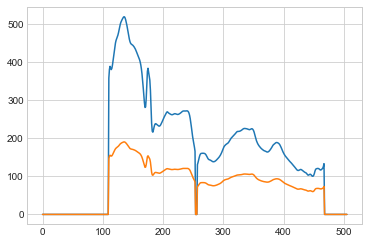

In [24]:
cvf0 = f0statis.convert(src_f0list[0], srcf0stats, tarf0stats)
plt.plot(cvf0)
plt.plot(src_f0list[0])

In [25]:
cvmcep_wGV = gv.postfilter(cv_mceps[0], srcgvstats, cvgvstats=cvgvstats)
cvf0 = f0statis.convert(src_f0list[0], srcf0stats, tarf0stats)
wav = synthesizer.synthesis(cvf0, cvmcep_wGV, src_aplist[0], rmcep=src_mceplist[0])
sf.write(output_path + "te.wav", wav, 16000)